ЗАДАЧИ:
1. Скорректировать исходные данные для 2 форматов отчетов с данными (переименовать, создать новые столбцы (с использованием регулярных выражений, замен))
2. Сделать шаблоны для отчетов и графиков по трем видам отчетов (динамические, количественные, структурные)
3. Создать html шаблон с выводом отчетов, графиков, "шапки" и "подвала" страницы, словаря, номера страницы
4. Создать шаблон с параметрами отчетов (показатели, названия...) 
5. Сформировать pdf отчет


In [1]:
pip install PyPDF2 


     |████████████████████████████████| 81kB 2.1MB/s 
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-cp36-none-any.whl size=61086 sha256=01e5c3dba19190228609ac1503f31affdd4a1f32fd2fc5470fb53138298d65ae
  Stored in directory: /root/.cache/pip/wheels/53/84/19/35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
Successfully built PyPDF2


In [2]:
pip install docxtpl


     |████████████████████████████████| 5.5MB 3.6MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.10-cp36-none-any.whl size=184491 sha256=f7dc66331bb1ec2568129bb51841c7c5b7568ee411762b03ee6cfc9686a322e3
  Stored in directory: /root/.cache/pip/wheels/18/0b/a0/1dd62ff812c857c9e487f27d80d53d2b40531bec1acecfa47b
Successfully built python-docx


In [3]:
pip install weasyprint

     |████████████████████████████████| 307kB 2.8MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 71kB 5.4MB/s 
     |████████████████████████████████| 1.9MB 9.7MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.2.0-cp36-none-any.whl size=89548 sha256=341f9d46379e5e86f47b4d7ecc2cf11667044759a8123de926c94ef17692dfe3
  Stored in directory: /root/.cache/pip/wheels/40/76/48/f1effadceea83b32e7d957dd0f92db4db8b537d7b72b4ef374
Successfully built cairocffi


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import weasyprint
                  
plt.rcParams.update({'figure.max_open_warning': 0})  
import re
import datetime


In [5]:
from google.colab import drive
drive.mount('/content/mntdrive')

Mounted at /content/mntdrive


In [6]:
FileReport = pd.read_excel("/content/mntdrive/My Drive/МК_report/DSReport.xlsx")


In [7]:
FileReport_fr = pd.read_excel("/content/mntdrive/My Drive/МК_report/DSreport_fr.xlsx")

In [8]:
WEEK_NAME_LIST = ['01/02 - 02/02', '03/02 - 09/02', '10/02 - 16/02', '17/02 - 23/02', '24/02 - 29/02']

MONTH = "Февраль 2020 г"

In [9]:
FileReport.rename(columns={'Quantity':'Выходы',
                           'Date':'Дата',
                           'Consolidated cost':'Бюджет (усл.ед.)',
                          'Duration':'Длительность (сек)',
                          'Clip expected duration':'Длительность роликов (сек)',
                          'TVCompany':'Телеканалы',
                           'Day type':'Тип дня недели',
                          'Week day':'День недели',
                          'Clip distribution':'Дистрибьюция ролика',
                          'Clip type':'Формат ролика','Article Level4' : 'Группа товаров',
                          'Clip' : 'Ролик',
                          'Article Level3':'Категория товара', 'Advertisers list' : "Рекламодатели",
                           "Programme genre":"Жанр_программы"},inplace=True)




In [10]:
#КОРРЕКТИРОВКА FILEREPORT

#Новые столбцы
FileReport['Номер_недели'] = FileReport['Дата'].dt.isocalendar().week
FileReport['Час_выхода'] = pd.to_datetime(FileReport['Время начала'].astype(str)).dt.hour.astype(int)
FileReport['Бюджет (тыс.усл.ед.)'] = FileReport['Бюджет (усл.ед.)']/1000
FileReport['Минуты'] = FileReport['Длительность роликов (сек)']/60 


# столбец Телеканалы_ТОП, в котором только список из каналов (80% от всех минут), а остальные = 'Остальные ТК'
TV_cut_list = FileReport.groupby(['Телеканалы'])['Минуты'].sum().sort_values(ascending = False)
TV_cut_list = ((TV_cut_list.div(TV_cut_list.sum(), axis=0) * 100)).cumsum() 
TV_cut_list  = TV_cut_list[TV_cut_list <=81]
TV_cut_list = TV_cut_list.index
FileReport['Телеканалы'] = FileReport['Телеканалы'].apply(lambda x: x if x in TV_cut_list else "Остальные ТК")

TV_CAT_FOR_LEGENDS =FileReport['Телеканалы'].unique().tolist()

#столбец 'название недели'. 
# 1) создаем словарь (номер недели-название недели)
# 2) меняем номер недели на название недели из словаря
list_week_for_number = FileReport["Номер_недели"].unique()
slovar_nedel = {}
for i,m in zip(WEEK_NAME_LIST,list_week_for_number):  
    slovar_nedel[m] = i    
FileReport['Название_недели'] = FileReport['Номер_недели'].apply(lambda x: slovar_nedel[x])       

#замена формата даты без времени (%Y?)
FileReport['Дата'] = FileReport['Дата'].dt.strftime('%d/%m')

#Если важен порядок ТМ в таблицах - делаем категорию. 
FileReport['Телеканалы']=FileReport['Телеканалы'].astype('category')
FileReport['Телеканалы'].cat.set_categories(TV_CAT_FOR_LEGENDS,inplace=True)

#максимальный и минимальный номер недели (для формирования отчета)
WEEKMIN=FileReport["Номер_недели"].min()    
WEEKMAX=FileReport["Номер_недели"].max()



In [11]:
#столбец с ценой товара от и до
def goods_price (str):
    text = str['Ролик']           
    text = text.replace(' ','').replace('8800','8-800-').replace('2020г','')  
    match = re.search(r'([0-9]{3,5}(?!-))', text)
    if match is None:
        text = int('0' )
    else:
        text = int(match.group())
    if text == 0:
        return 'NA or 0' 
    elif text <= 1500:
        return 'до 1500р.'
    elif  text >= 1501 and text <= 2998 : 
        return 'от 1501-2998р'   
    elif  text >= 2999 and text <= 4500 :   
        return  'от 2999-4500р.'
    elif  text >= 4501 :
        return 'от 4501р. '

FileReport['Цена товара (руб.)'] = FileReport.apply(goods_price, axis = 1) 

# print(FileReport[['Цена товара (руб.)','Ролик']])                        

In [12]:
#столбец Категория товара (сокр) (сокращенный вариант)
FileReport['Категория товара (сокр)'] = FileReport['Категория товара']
FileReport['Категория товара (сокр)'] = FileReport['Категория товара (сокр)'].apply(lambda x: x.replace("ИНТЕРНЕТ-ТОРГОВЛЯ, КУХОННЫЕ ПРИНАДЛЕЖНОСТИ, КУХОННЫЕ ПРИНАДЛЕЖНОСТИ, МЕЛКАЯ БЫТОВАЯ ТЕХНИКА ДЛЯ КУХНИ","МЕЛКАЯ БЫТОВАЯ ТЕХНИКА ДЛЯ КУХНИ").replace("ИНТЕРНЕТ-ТОРГОВЛЯ, МЕЛКАЯ БЫТОВАЯ ТЕХНИКА ДЛЯ КУХНИ, КУХОННЫЕ ПРИНАДЛЕЖНОСТИ, КУХОННЫЕ ПРИНАДЛЕЖНОСТИ","МЕЛКАЯ БЫТОВАЯ ТЕХНИКА ДЛЯ КУХНИ").replace("ИНТЕРНЕТ-ТОРГОВЛЯ, МЕЛКАЯ БЫТОВАЯ ТЕХНИКА ДЛЯ КУХНИ, КУХОННЫЕ ПРИНАДЛЕЖНОСТИ, КУХОННЫЕ ПРИНАДЛЕЖНОСТИ", "МЕЛКАЯ БЫТОВАЯ ТЕХНИКА ДЛЯ КУХНИ").replace("ОДЕЖДА, ОДЕЖДА, ТОРГОВЫЕ ОРГАНИЗАЦИИ"," ОДЕЖДА").replace("МЕЛКАЯ БЫТОВАЯ ТЕХНИКА ДЛЯ КУХНИ, КУХОННЫЕ ПРИНАДЛЕЖНОСТИ, КУХОННЫЕ ПРИНАДЛЕЖНОСТИ, ИНТЕРНЕТ-ТОРГОВЛЯ","МЕЛКАЯ БЫТОВАЯ ТЕХНИКА ДЛЯ КУХНИ").replace("ИНТЕРНЕТ-ТОРГОВЛЯ, МЕЛКАЯ БЫТОВАЯ ТЕХНИКА ДЛЯ КУХНИ, КУХОННЫЕ ПРИНАДЛЕЖНОСТИ, КУХОННЫЕ ПРИНАДЛЕЖНОСТИ","МЕЛКАЯ БЫТОВАЯ ТЕХНИКА ДЛЯ КУХНИ").replace("ИНТЕРНЕТ-ТОРГОВЛЯ, МЕЛКАЯ БЫТОВАЯ ТЕХНИКА ДЛЯ КУХНИ, КУХОННЫЕ ПРИНАДЛЕЖНОСТИ, КУХОННЫЕ ПРИНАДЛЕЖНОСТИ", "МЕЛКАЯ БЫТОВАЯ ТЕХНИКА ДЛЯ КУХНИ"))
FileReport['Категория товара (сокр)']  = FileReport['Категория товара (сокр)'] .apply(lambda x: x.replace("ИНТЕРНЕТ-ТОРГОВЛЯ","").replace("ТОРГОВЫЕ ОРГАНИЗАЦИИ",""). replace("КОСВЕННАЯ РЕКЛАМА","").replace(",",""))
FileReport['Категория товара (сокр)']  = FileReport['Категория товара (сокр)'] .apply(lambda x: x.strip())
#проверка какие считать остальными. Таблица по категориям сумма минут
table = FileReport.groupby('Категория товара (сокр)')['Минуты'].sum()  
table = table.sort_values(ascending = False)    
#Берем ТОП10
table_cut = table[0:11]  
#список из категорий, которые подйут под "остальные" 
ostalnie_spisok = table_cut.index.tolist()   
# замена остальных
FileReport.loc[~FileReport['Категория товара (сокр)'].isin(ostalnie_spisok) , 'Категория товара (сокр)'] = 'ОСТАЛЬНЫЕ' 

sorted(FileReport['Категория товара (сокр)'].unique())

corrected_categories = ['АВТОАКСЕССУАРЫ','АКСЕССУАРЫ ДЛЯ ОДЕЖДЫ','КУХОННЫЕ ПРИНАДЛЕЖНОСТИ',
                        'МЕДИЦИНСКИЕ МАТЕРИАЛЫ','МЕЛКАЯ БЫТОВАЯ ТЕХНИКА КУХНЯ','МЕЛКАЯ БЫТОВАЯ ТЕХНИКА ДЛЯ ХОЗЯЙСТВА',
                        'ОДЕЖДА', 'ОСТАЛЬНЫЕ',  'ПРЕДМЕТЫ ИНТЕРЬЕРА', 'СТРОИТЕЛЬНЫЕ ИНСТРУМЕНТЫ', 
                        'ТЕКСТИЛЬНЫЕ ИЗДЕЛИЯ', 'ХОЗЯЙСТВЕННЫЕ ПРИНАДЛЕЖНОСТИ']
dict_category_cut= dict(zip(list(sorted(FileReport['Категория товара (сокр)'].unique())), (corrected_categories) ))
FileReport['Категория товара (сокр)'] = FileReport['Категория товара (сокр)'].apply(lambda x: dict_category_cut[x].lower())

In [13]:
#КОРРЕКТИРОВКА FILEREPORT_FR
FileReport_fr.rename(columns={'Quantity':'Выходы',
                            'Duration (сек)':'Длительность (сек)',     
                            'Consolidated cost, рубли':'Бюджет (усл.ед.)', 
                            "канал" : "Телеканалы", 
                            'период' : "Дата",'Frequen.':'Frequency',"рекламодатель":'Рекламодатели'
                                                       
                          },inplace=True)
# Удалить "все телеканалы"
FileReport_fr = FileReport_fr[FileReport_fr['Телеканалы'] != "ВСЕ КАНАЛЫ"]

# столбец с телеканалами
FileReport_fr['Телеканалы'] = FileReport_fr['Телеканалы'].apply(lambda x: x.replace(' (СЕТЕВОЕ ВЕЩАНИЕ)',""))
FileReport_fr['Телеканалы1'] = FileReport_fr['Телеканалы']
FileReport_fr['Телеканалы'] = FileReport_fr['Телеканалы'].apply(lambda x: x if x in TV_cut_list else "Остальные ТК")

# #Если важен порядок ТК в таблицах - делаем категорию. 
FileReport_fr['Телеканалы']=FileReport_fr['Телеканалы'].astype('category')
FileReport_fr['Телеканалы'].cat.set_categories(TV_CAT_FOR_LEGENDS,inplace=True)

# Новые столбцы
FileReport_fr['Длительность (мин)'] = FileReport_fr['Длительность (сек)'].astype(int)/60
FileReport_fr['CPT Aud (руб)'] = FileReport_fr['Бюджет (усл.ед.)'] / FileReport_fr['Audience, тыс.чел']
FileReport_fr['CPT Reach (руб)'] = FileReport_fr['Бюджет (усл.ед.)'] / FileReport_fr['Reach, тыс.чел']

#Добавляем столбцы с неделей и месяцем. Задача - в столбце дни только подневные данные, в столбце с названиями недель и месяцев - только понедельные и помесячные данные
FileReport_fr["Название_недели"] = FileReport_fr["Дата"]
FileReport_fr["Название_недели"] = FileReport_fr["Название_недели"].apply(lambda x: x if x in  WEEK_NAME_LIST else "")
FileReport_fr["Месяц_название"] = FileReport_fr["Дата"].apply(lambda x: x if x == MONTH else "")
FileReport_fr["Дата"] = FileReport_fr["Дата"].apply(lambda x: "" if x in WEEK_NAME_LIST or x == MONTH else x)
FileReport_fr['Номер_недели'] = FileReport_fr['Дата'].dt.isocalendar().week

# # Добавление в номера недель номера недель по столбцу "Название недели"
slovar_nedel_visaversa = {}
for k, n in slovar_nedel.items():
    slovar_nedel_visaversa[n] = k

def week_number(row):
    if  (row["Название_недели"] != "") :
        return slovar_nedel_visaversa[row["Название_недели"]]
    else:
        return row['Номер_недели']
FileReport_fr['Номер_недели'] = FileReport_fr.apply(week_number, axis=1)

# #замена формата даты без времени (%Y?)
FileReport_fr['Дата'] = pd.to_datetime(FileReport_fr['Дата']).dt.strftime('%d/%m')



In [14]:
FileReport_fr.to_excel("Filereport_fr1.xls")
FileReport_fr.to_excel("Filereport1.xls")

In [15]:
# Проверить данные
#Нужно проверить список рекламодателей и для set.categories !!!
print(len(FileReport['Телеканалы'].unique()) == len(TV_CAT_FOR_LEGENDS))
print(len(FileReport_fr['Телеканалы'].unique()) == len(TV_CAT_FOR_LEGENDS))



True
True


In [16]:
# Форматы чисел

#форматы данных для float
pd.options.display.float_format = lambda x: '{:,.1f}'.format(x).replace(",", " ")

#форматы данных для int (нужно изменить изначально определенное форматом pandas)
class _IntArrayFormatter(pd.io.formats.format.GenericArrayFormatter):
    def _format_strings(self):
        formatter = self.formatter or (lambda x: ' {:,}'.format(x).replace(',',' '))
        fmt_values = [formatter(x) for x in self.values]
        return fmt_values
pd.io.formats.format.IntArrayFormatter = _IntArrayFormatter



In [17]:
# Данные для графиков

#цвета и легенда графиков 
colors_pie=('#5F9EA0', "#D8BFD8", "#DEB887","#F4A460","#B8860B","#8B4513","#AA981C","#D3D3D3","#696969","#778899")
colors_plot=('#5F9EA0', "#D8BFD8", "#DEB887","#F4A460","#B8860B","#8B4513","#FAEBD7","#D3D3D3","#AA981C","#696969","#778899")
colors_bar=('#5F9EA0', "#D8BFD8", "#DEB887","#F4A460","#B8860B","#8B4513","#FAEBD7","#D3D3D3","#AA981C","#696969","#778899")
colors_structure = ("#5F9EA0", "#D8BFD8", "#DEB887","#F4A460","#B8860B","#8B4513","#A52A2A","#FAEBD7","#D3D3D3","#AA981C","#696969","#778899","#2F4F4F","#20B2AA","#008B8B","#00FFFF","#FFFACD","#48D1CC","#5F9EA0","#4682B4","#B0C4DE","#B0E0E6","#87CEFA","#00BFFF","#6495ED","#EEE8AA","#F0E68C")
if len(colors_pie) < len(TV_CAT_FOR_LEGENDS) or len(colors_plot)< len(TV_CAT_FOR_LEGENDS) or len(colors_bar)< len(TV_CAT_FOR_LEGENDS):
    print("ПРОВЕРИТЬ!!!")

label_list = TV_CAT_FOR_LEGENDS

#функция для того, чтобы если значение на оси было большим, использовались тыс.(млн)
def def_yx_fmt(tick_val,pos = None):                    
        if tick_val > 1000000:
            val = int((tick_val)/1000000)               
            return '{:d}млн.'.format(val)                
        elif tick_val > 10000:
            val = int((tick_val)/1000)                   
            return '{:d}тыс.'.format(val)                
        else: 
            val = int(tick_val)
            return '{:d}'.format(val)             

In [18]:
#Названия файлов для формирования отчетов
#шаблон для html
template_html = ("/content/mntdrive/My Drive/МК_report/template_fr(3).html")         
#html файл с таблицами-графиками     
html_file = "finalTV.html"
#pdf файл с таблицами-графиками                   
reports_pdf_file_month = 'report_grphs_TV_month.pdf' 
reports_pdf_file_weeks = 'report_grphs_TV_weeks.pdf' 

#словарь определений для отчета
SLOVAR_DEFINITION = {'Бюджет (тыс.усл.ед.)':'Бюджет (усл.ед.) - приведенный бюджет рекламы, который рассчитывается исходя из типа оценки рекламного блока. Для выпусков реклам в блоке, который оценивается по GRP, приведенный бюджет равен бюджету по GRP (даже в том случае, когда этот бюджет равен 0). В случае, когда данный рекламный блок не оценивается по GRP, приведенный бюджет выпуска рекламы равен бюджету этого выпуска по «минутным» прайс-листам.','18+ TVR':'Телевизионный рейтинг (TVR) — показатель, характеризующий процент аудитории, контактировавший с конкретным эфирным событием (ТВ-программой, рекламным блоком, рекламным роликом и т.д.)','18+ Stand. TVR (20)':'Stand. TVR (20), % - сумма TVR событий, приведенных к некоторой «стандартной» длительности. Основное назначение – удобный и быстрый подсчет «покупаемых» (например, 20-секундных) рейтингов для группы событий (например, отобранных роликов для посткампейна)', '18+ Stand. TVR (30)':'Stand. TVR (30), % - сумма TVR событий, приведенных к некоторой «стандартной» длительности. Основное назначение – удобный и быстрый подсчет «покупаемых» (например, 30-секундных) рейтингов для группы событий (например, отобранных роликов для посткампейна).','Std. Sales TVR (20)':'Std. Sales TVR (20) -cумма TVR (ТВ Рейтинг) событий рассчитанных на баинговую аудиторию канала, приведенных к «стандартной» длительности медийного события (20 секунд).','Std. Sales TVR (30)': 'Std. Sales TVR (30) -cумма TVR (ТВ Рейтинг) событий рассчитанных на баинговую аудиторию канала, приведенных к «стандартной» длительности медийного события (30 секунд).','Audience, тыс.чел':'Audience (аудитория)  эфирного события (выражается в тысячах человек).Audience для отдельного события – это среднее число людей в целевой группе, которые хоть сколько-то времени видели/смотрели  это событие на протяжении всего периода его длительности.Каждое эфирное событие уникально, при повторении эфирного события (например, повторный выход р/р) человек считается  ещё раз. В отчете рассчитан для целевой аудитории 4+.','Reach, тыс.чел':'Охват или Reach (тыс. человек) - количество тысяч человек в анализируемой целевой группе, смотревших эфирное событие целиком или не менее одной минуты.  Каждое эфирное событие уникально, при повторении эфирного события (например, повторный выход р/р) человек считается ещё раз. В отчете рассчитан для целевой аудитории 4+.','охват 4+ %' : 'Reach N+ (Охват N+) (тыс. человек)   -для повторяющихся эфирных событий (например, выход рекламного ролика) - количество тысяч человек в анализируемой целевой группе, смотревших не менее N повторов эфирного события   целиком или не менее одной минуты. В отчете рассчитан для целевой аудитории 4+.','охват 1+ %' :  'Reach N+ (Охват N+) (тыс. человек) - для повторяющихся эфирных событий (например, выход рекламного ролика) - количество  тысяч человек в анализируемой целевой группе, смотревших не менее N повторов эфирного события целиком или не менее одной минуты. В отчете рассчитан для целевой аудитории 4+.','Frequency' : 'Частота (англ. Frequency) — количество контактов одного представителя аудитории с повторяющимся эфирным событием на заданном интервале времени. Обычно расчётная величина, один из целевых параметров при медиапланировании. При анализе медиа характеризует рекламный шум. В отчете рассчитан для целевой аудитории 4+.','CPT Aud (руб)' : 'СРТ (Cost-per-thousand или Цена за тысячу) - стоимость 1000 рекламных контактов. Вычисляется как отношение рекламного бюджета на его Audience (аудиторию) эфирного события (выраженную в тысячах человек). В отчете рассчитан для целевой аудитории 4+.','CPT Reach (руб)' : "СРТ Reach (Cost-per-thousand или Цена за тысячу) - стоимость 1000 рекламных контактов с людьми человек в анализируемой целевой группе, смотревших эфирное событие целиком или не менее одной минуты. Вычисляется как отношение рекламного бюджета на Reach (выраженную в тысячах человек). В отчете рассчитан для целевой аудитории 4+." , "охват 7+ %" : "Reach N+ (Охват N+) (тыс. человек) - для повторяющихся эфирных событий (например, выход рекламного ролика) - количество тысяч человек в анализируемой целевой группе, смотревших не менее N повторов эфирного события целиком или не менее одной минуты. В отчете рассчитан для целевой аудитории 4+." }
def def_definition_list(parametr_list):
    definition_list = []                        
    for i in parametr_list:
        if i in SLOVAR_DEFINITION:              
            definition_list.append(SLOVAR_DEFINITION[i])  
        else:
            definition_list.append('')                     
    return definition_list



In [19]:
#чтобы сортировать по порядку 'дни недели' (в столбцах и строках) 
def def_if_structure_parametr_den_nedeli_index (table):
    table.rename(index={'Понедельник' : int(1),'Вторник':int(2),
                        'Среда':int(3),'Четверг':int(4),'Пятница':int(5),
                        'Суббота':int(6),'Воскресенье':int(7),'Итого':int(10)}, inplace=True)
    table.sort_index(inplace=True)                      
    table.rename(index={1:'Понедельник' ,2:'Вторник',3:'Среда',4:'Четверг',5:'Пятница',6:'Суббота',7:'Воскресенье',10:'Итого'}, inplace=True)
    return table

def def_if_structure_parametr_den_nedeli_columns (table):
    table.rename(columns={'Понедельник' : int(1),'Вторник':int(2),
                     'Среда':int(3),'Четверг':int(4),'Пятница':int(5),
                        'Суббота':int(6),'Воскресенье':int(7),'Итого':int(10)}, inplace=True)
    table.sort_index(axis=1,inplace=True)                       
    table.rename(columns={1:'Понедельник' ,2:'Вторник',3:'Среда',4:'Четверг',5:'Пятница',6:'Суббота',7:'Воскресенье',10:'Итого'}, inplace=True)
    return table



In [20]:
#Таблицы для динамических отчетов (если указана неделя, то отчет по дням. Если за месяц - то отчет по недельно)
def get_dynamics_table_TV(FileReport, parametr_for_report, week  = None ):
    if week != None:  
        FileReport = FileReport[FileReport['Номер_недели'] == week]

        table = pd.pivot_table(FileReport, 
                               values = [parametr_for_report], 
                               columns = ['Дата'],index  = ['Телеканалы'],
                               aggfunc = 'sum', margins_name = 'Итого', 
                               fill_value = 0,  
                               margins = True)   
        table_gr = pd.pivot_table(FileReport, 
                               values = [parametr_for_report], 
                               index = ['Дата'],columns = ['Телеканалы'],
                               aggfunc = 'sum', margins_name = 'Итого', 
                               fill_value = 0,  
                               margins = True)                
    else:
        table = pd.pivot_table(FileReport,
                         values=[parametr_for_report],
                         columns=['Название_недели'],
                         index=['Телеканалы'],
                         aggfunc='sum',
                         margins_name='Итого',                
                         fill_value=0,                        
                         margins=True)  
        table_gr  = pd.pivot_table(FileReport,
                         values=[parametr_for_report],
                         index=['Название_недели'],
                         columns=['Телеканалы'],
                         aggfunc='sum',
                         margins_name='Итого',                
                         fill_value=0,                        
                         margins=True)                   
    return table,table_gr

#get_dynamics_table_TV(FileReport, 'Выходы')  #проверка


In [21]:
#Таблицы для динамических отчетов FR (если указана неделя, то отчет по дням. Если за месяц - то отчет по недельно)
#Margins и данные по "остальным ТК" каналам не выводим
def get_dynamics_table_FR_TV(FileReport, parametr_for_report, week  = None ):
    if week != None:  
        FileReport = FileReport[(FileReport['Номер_недели'] == week)\
                                &(FileReport['ЦА']=='Total')\
                                & (FileReport['Рекламодатели'] == "ВСЕ ТЕЛЕМАГАЗИНЫ")\
                                & (FileReport["Название_недели"] == "")]
        
        table = pd.pivot_table(FileReport,
                         values = [parametr_for_report],
                         columns = ['Дата'],
                         index = ['Телеканалы'],
                         aggfunc = 'sum',
                         margins_name = 'Итого',            
                         fill_value = 0,                    
                         margins = False)                   
        
        table_gr = pd.pivot_table(FileReport,
                         values = [parametr_for_report],
                         index = ['Дата'],
                         columns = ['Телеканалы'],
                         aggfunc = 'sum',
                         margins_name = 'Итого',            
                         fill_value = 0,                    
                         margins = False)    

    else:
        FileReport =  FileReport[FileReport['ЦА']=='Total']  
        FileReport = FileReport[FileReport['Рекламодатели'] == "ВСЕ ТЕЛЕМАГАЗИНЫ"]
        FileReport = FileReport[FileReport["Название_недели"] != ""]
               
        table = pd.pivot_table(FileReport,  values=[parametr_for_report],
                         columns=['Название_недели'],
                         index=['Телеканалы'],
                         aggfunc='sum',
                         margins_name='Итого',                
                         fill_value=0,                        
                         margins=False)
        table_gr = pd.pivot_table(FileReport,
                         values=[parametr_for_report],
                         index=['Название_недели'],
                         columns=['Телеканалы'],
                         aggfunc='sum',
                         margins_name='Итого',                
                         fill_value=0,                        
                         margins=False)                     
    
    table = table.iloc[:-1,:]     
    table_gr = table_gr.iloc[:,:-1]     
    return table, table_gr



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

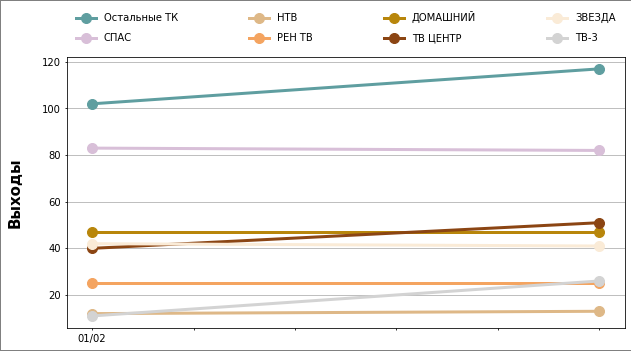

In [22]:
# График линейный для динамических отчетов

def get_lineplot_TV(FileReport, parametr_for_report, week  = None ):  
    table, table_gr = get_dynamics_table_TV (FileReport, parametr_for_report, week  = week )   
    
    table_gr = table_gr.iloc[:-1,:-1]                               
    fig = plt.figure( figsize=(10, 5),
                     frameon=True,
                     edgecolor='grey',                          
                     facecolor='#ffffff',                       
                     linewidth=2)                               
    ax = fig.add_subplot(111)                                  
    table_gr.plot(ax = ax, linewidth = 3, color = colors_plot, marker = 'o', markersize = 10)                           
                                     
                                               
    ax.set_title('',loc = 'center',fontfamily = 'serif',color = 'black',size = 20) #Название
    ax.set_xlabel("",labelpad = 20, 
                  weight = 'bold', 
                  fontfamily = 'Arial', 
                  size = 15)
    ax.set_ylabel(f'{parametr_for_report}', 
                  labelpad = 20,  
                  weight = 'bold', 
                  fontfamily = 'Arial',
                  size = 15)
    ax.grid(axis = 'y')                                        
    ax.legend(labels = label_list, 
              fontsize = 10, 
              loc = 'upper center', 
              frameon = 0,  mode = 'expand',
              ncol = 4,  
              labelspacing = 1, 
              bbox_to_anchor = (0, 0.2,1,1))                     
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(def_yx_fmt)) #если значения большие, то ось y в млн
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(30))     #интервал по оси
    ax.tick_params(axis = 'x',                               
                   which = 'major',                             
                   labelsize = 10, 
                   labelrotation = 0,                         
                   length = 2)                                  
    ax.tick_params(axis = 'y',                               
                   which = 'major',                             
                   labelsize = 10,  
                   length = 2)                                  
    fig.savefig("TV_plot_{}_неделя{}.png".format(parametr_for_report,week),bbox_inches='tight',) 
plt.tight_layout()   
get_lineplot_TV(FileReport, 'Выходы',5) 


<Figure size 432x288 with 0 Axes>

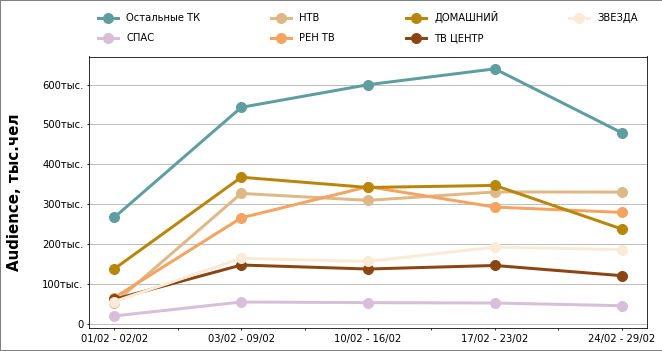

In [23]:
#График линейный для динамических отчетов FR
def get_lineplot_FR_TV(FileReport, parametr_for_report, week  = None ):  
    
    table, table_gr = get_dynamics_table_FR_TV (FileReport, parametr_for_report, week  = week )    
    #table_gr = table_gr.iloc[:-1,:-1]                              
    fig = plt.figure( figsize=(10, 5),
                     frameon=True,
                     edgecolor='grey',                          
                     facecolor='#ffffff',                       
                     linewidth=2)                               
    ax = fig.add_subplot(111)                                   
    table_gr.plot(ax = ax, linewidth = 3, color = colors_plot, marker = 'o', markersize = 10)                           
                                     
                                               
    ax.set_title('',loc = 'center',fontfamily = 'serif',color = 'black',size = 20) 
    ax.set_xlabel("",labelpad = 20, 
                  weight = 'bold', 
                  fontfamily = 'Arial', 
                  size = 15)
    ax.set_ylabel(f'{parametr_for_report}', 
                  labelpad = 20,  
                  weight = 'bold', 
                  fontfamily = 'Arial',
                  size = 15)
    ax.grid(axis = 'y')    
    
    # без остальных ТК
    ax.legend(labels = label_list[:-1], fontsize = 10, 
              loc = 'upper center', 
              frameon = 0,  mode = 'expand',
              ncol = 4,  
              labelspacing = 1, 
              bbox_to_anchor = (0, 0.2,1,1))                      
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(def_yx_fmt)) #если значения большие, то ось y в млн
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(30))     #интервал по оси
    ax.tick_params(axis = 'both',                               
                   which = 'major',                             
                   labelsize = 10, 
                   labelrotation = 0,                          
                   length = 2)                                  
 
    fig.savefig("TV_FRplot_{}_неделя{}.png".format(parametr_for_report,week),bbox_inches='tight',) #сохранение
plt.tight_layout()   
get_lineplot_FR_TV(FileReport_fr, 'Audience, тыс.чел') 


In [24]:
#Таблица для количественных отчетов (без разбивки на дни-недели)

def get_kolichestvo_table_html_TV (FileReport, parametr_for_report, week  = None):
    if week != None:
        table = FileReport[FileReport['Номер_недели'] ==week].groupby('Телеканалы').sum()[parametr_for_report]
    else:
        table = FileReport.groupby('Телеканалы').sum()[parametr_for_report]
    table_html = pd.DataFrame([table])                  #первести в dataframe (Рекламодатели в столбцах)
    return table_html
get_kolichestvo_table_html_TV(FileReport,'Бюджет (тыс.усл.ед.)',week=6)   


Телеканалы            Остальные ТК    СПАС      НТВ  ...  ТВ ЦЕНТР  ЗВЕЗДА     ТВ-3
Бюджет (тыс.усл.ед.)      78 090.4 9 362.1 30 424.8  ...   7 113.8 7 496.5 18 686.3

[1 rows x 8 columns]

In [25]:
#Таблица для количественных отчетов FR (без разбивки на дни-недели)

def get_kolichestvo_table_html_FR_TV (FileReport, parametr_for_report, week  = None):
    if week != None:
        FileReport = FileReport[FileReport['Номер_недели'] == week]
        FileReport = FileReport[FileReport['ЦА']=='Total']  
        FileReport = FileReport[FileReport['Рекламодатели'] == "ВСЕ ТЕЛЕМАГАЗИНЫ"]
        FileReport = FileReport[FileReport["Название_недели"] != ""]
        table = FileReport.groupby('Телеканалы')[parametr_for_report].sum()
    else:
        FileReport = FileReport[FileReport['ЦА']=='Total']  
        FileReport = FileReport[FileReport['Рекламодатели'] == "ВСЕ ТЕЛЕМАГАЗИНЫ"]
        FileReport = FileReport[FileReport["Месяц_название"] != ""]
        table = FileReport.groupby('Телеканалы')[parametr_for_report].sum()
    
    table_html = pd.DataFrame([table])
    table_html =  table_html.iloc[:,:-1]
    return  table_html

get_kolichestvo_table_html_FR_TV (FileReport_fr,'Audience, тыс.чел',week=6)   #проверка


Телеканалы         Остальные ТК     СПАС  ...  ТВ ЦЕНТР    ЗВЕЗДА
Audience, тыс.чел     542 802.1 55 293.4  ... 147 882.0 164 650.0

[1 rows x 7 columns]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # Remove the CWD from sys.path while we load stuff.


<Figure size 432x288 with 0 Axes>

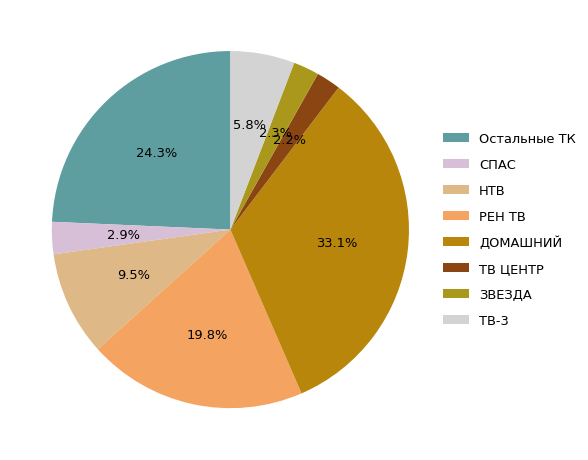

In [26]:
# График для количественных отчетов (pie)
def get_pie_TV (FileReport, parametr_for_report, week  = None ):  
    
    table = get_kolichestvo_table_html_TV (FileReport, parametr_for_report, week  = week)
        
    fig, ax = plt.subplots()                                      
    fig.set_figwidth(8)
    fig.set_figheight(10)
    ax.pie(table,
        autopct='%1.1f%%',frame=False, colors=colors_pie, textprops=dict(fontsize=13), startangle=90,  labeldistance=1.1) 
    ax.legend(labels = label_list, 
              fontsize = 13, 
              loc = 7, 
              frameon = 0,  
              ncol = 1,  
              labelspacing = 1, bbox_to_anchor=(1.3, 0.5))
    fig.savefig("TV_pie_{}_неделя{}.png".format(parametr_for_report, week),bbox_inches='tight') #сохранение
    
plt.tight_layout()    
get_pie_TV(FileReport, 'Бюджет (усл.ед.)',week = 6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if __name__ == '__main__':


<Figure size 432x288 with 0 Axes>

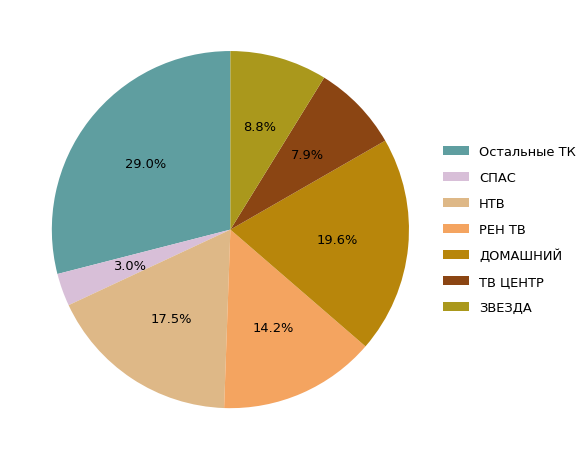

In [27]:
# График для количественных отчетов FR (pie) 
def get_pie_FR_TV (FileReport, parametr_for_report, week  = None ):  
    table = get_kolichestvo_table_html_FR_TV (FileReport, parametr_for_report, week  = week).T     
    
    fig, ax = plt.subplots()                                      
    fig.set_figwidth(8)
    fig.set_figheight(10)
    ax.pie(table,
        autopct='%1.1f%%',frame=False, colors=colors_pie, textprops=dict(fontsize=13), startangle=90,  labeldistance=1.1) 
    ax.legend(labels = label_list, 
              fontsize = 13, 
              loc = 7, 
              frameon = 0,  
              ncol = 1,  
              labelspacing = 1, bbox_to_anchor=(1.3, 0.5))  
    fig.savefig("TV_FRpie_{}_неделя{}.png".format(parametr_for_report, week),bbox_inches='tight') #сохранение
    #fig.savefig(f'pie_{parametr_for_report}_неделя{str(week)}.png',bbox_inches='tight')
plt.tight_layout()    
get_pie_FR_TV(FileReport_fr,'Audience, тыс.чел', week =6)


In [28]:
#Таблица для стурктурного отчета (гистограмма)

def get_structure_table_TV (FileReport, structure_value, structure_parametr, week = None):
    if week != None:  
        FileReport = FileReport[FileReport['Номер_недели'] == week]
    else:
        FileReport = FileReport        
    
    table = pd.pivot_table(FileReport, values=[structure_value], 
                           index=[structure_parametr],
                           columns=['Телеканалы'],
                           aggfunc='sum', margins_name='Итого', 
                           fill_value=0,   margins=True)                          
       
    if structure_parametr == 'День недели':                 
        def_if_structure_parametr_den_nedeli_index (table)
    
    #сортировка
    # сортировка  (сначала срортируем без margin, потом добавялем строку Итого)
    elif structure_parametr == 'Час_выхода' or structure_parametr =='Длительность роликов (сек)' or structure_parametr ==  "Цена товара (руб.)":
         table1 = table.iloc[:-1].sort_values(by = structure_parametr)
         table = table1.append(table.iloc[-1:])
    else:     
        table = table.sort_values((structure_value,'Итого'),    # сортируем по ИТОГО
                              ascending = True) 
        
    table = table.replace(0.0,'-').replace(0,'-')             
    return table
      

get_structure_table_TV (FileReport, 'Минуты', 'Длительность роликов (сек)') #проверка


Минуты             ...                      
Телеканалы                 Остальные ТК  СПАС  НТВ  ... ЗВЕЗДА  ТВ-3    Итого
Длительность роликов (сек)                          ...                      
0                                     -     -    -  ...      -     -        -
30                                    -     -    -  ...     83     -     83.0
45                                    -     -    -  ...      -     -      9.8
50                                    -     -    -  ...      -     -      5.8
55                                    -     -    -  ...      -     -    174.2
60                              1 894.0   697  428  ...   1215   928  7 585.0
75                                663.8     -    -  ...      -     -    802.5
80                                    -     -    -  ...      -     -      1.3
90                                    -     -    -  ...      -     -    505.5
95                                    -     -    -  ...      -     -      1.6
100                                   -     -    -  ...      -     -     10.0
120                               602.0  1680  368  ...      -   228  3 134.0
135                                65.2     -    -  ...      -     -     65.2
160                                   -     -    -  ...      -     -     13.3
165                                   -     -    -  ...      -     -    451.0
180                               381.0  3069    -  ...      -     -  3 747.0
230                                   -     -    -  ...      -     -     11.5
240                                40.0     -    -  ...      -     -    664.0
Итого                           3 646.0  5446  796  ...   1298  1156 17 264.8

[19 rows x 9 columns]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


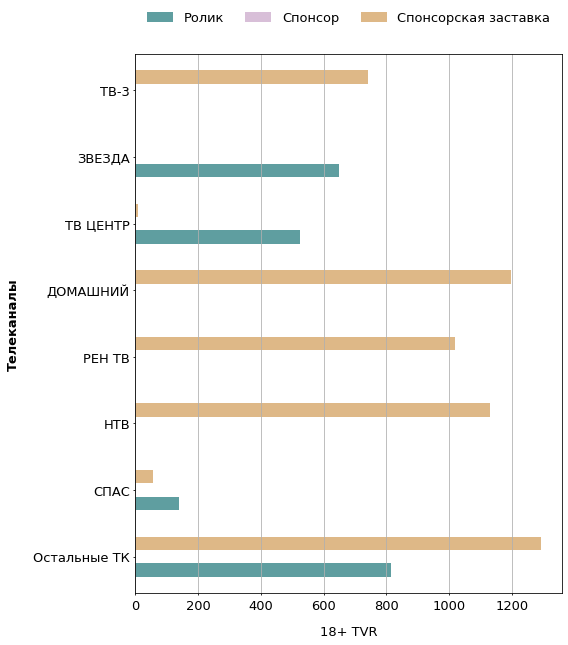

In [29]:
#График для структурного отчета

#нужна новая таблица с данными в колонках и без margin
def get_structure_bar_TV (FileReport, structure_value, structure_parametr, week = None):
    if week != None:  
        FileReport = FileReport[FileReport['Номер_недели'] == week]
    else:
        FileReport = FileReport
    table=pd.pivot_table(FileReport,                           
                     values=[structure_value],
                     columns=[structure_parametr],
                     index=['Телеканалы'],
                     aggfunc=sum,
                     fill_value=0)                                
    
    if structure_parametr == 'День недели':                     
        def_if_structure_parametr_den_nedeli_columns(table)
    
    
    #для графика
    #сделать список для легенды  без слова "выходы"
    spisok_columns = list(table.columns)           ##список из кортежа [(выходы,рабочий),(выходы,выходной)
    legend_list_correct = []                        #здесь хранится "правильный" список для легенды
    for x in spisok_columns:
        legend_list_correct.append(x[1])           
    
    #график
    fig, ax = plt.subplots(figsize = (8,9))
   
    #разный размер легенды
    if structure_parametr == 'Телеканалы' :
        table.plot(ax = ax, kind = 'barh', width = 1.3, color = colors_structure )
        ax.legend(labels = legend_list_correct,fontsize = 10,frameon = 0,loc = 'upper center', 
              mode = 'expand',ncol =2, labelspacing = 0.5, bbox_to_anchor = (0, 0.3,1,1))  
    elif structure_parametr == "Жанр_программы" or structure_parametr =='Категория товара (сокр)' :
        table.plot(ax = ax, kind = 'barh', width = 1.3, color = colors_structure )
        ax.legend(labels = legend_list_correct,fontsize = 10,frameon = 0,loc = 'upper center', 
              mode = 'expand',ncol = 2, labelspacing = 0.5, bbox_to_anchor = (0, 0.25,1,1))    
    elif structure_parametr == "Час_выхода":
        table.plot(ax = ax, kind = 'barh', width = 1.3, color = colors_structure )
        ax.legend(labels = legend_list_correct,fontsize = 10,frameon = 0,loc = 'upper center', 
              mode = 'expand',ncol = 5, labelspacing = 0.5, bbox_to_anchor = (0, 0.25,1,1))     
    elif structure_parametr == 'Длительность роликов (сек)':
        table.plot(ax = ax, kind = 'barh', width = 2.5, color = colors_structure )
        ax.legend(labels = legend_list_correct,fontsize = 13,frameon = 0,loc = 6, 
              mode = 'expand',ncol = 3, labelspacing =0.5, bbox_to_anchor = (0, 0.7,1,1))     
    elif structure_parametr ==  'Тип дня недели' or structure_parametr =='Дистрибьюция ролика'  :
        table.plot(ax = ax, kind = 'barh', width = 0.6, color = colors_structure )
        ax.legend(labels = legend_list_correct,fontsize = 15,frameon = 0,loc = 'upper center', 
              mode = 'expand',ncol = 3, labelspacing = 0.5, bbox_to_anchor = (0, 0.15,1,1))  
    elif structure_parametr  == 'Рекламодатели' or  structure_parametr  =='Формат ролика':
        table.plot(ax = ax, kind = 'barh', width = 0.6, color = colors_structure )
        ax.legend(labels = legend_list_correct,fontsize = 13,frameon = 0,loc = 'upper center', 
              mode = 'expand',ncol = 3, labelspacing = 0.5, bbox_to_anchor = (0, 0.1,1,1))   
    elif structure_parametr == "Цена товара (руб.)":
        table.plot(ax = ax, kind = 'barh', width = 0.6, color = colors_structure )
        ax.legend(labels = legend_list_correct,fontsize = 14,frameon = 0,loc = 'upper center', 
              mode = 'expand',ncol =2, labelspacing = 0.5, bbox_to_anchor = (0, 0.15,1,1))  
    elif structure_parametr == "День недели":
        table.plot(ax = ax, kind = 'barh', width = 0.6, color = colors_structure )
        ax.legend(labels = legend_list_correct,fontsize = 14,frameon = 0,loc = 'upper center', 
            mode = 'expand',ncol =3, labelspacing = 0.5, bbox_to_anchor = (0, 0.20,1,1))    
     
    else:
        table.plot(ax = ax, kind = 'barh', width = 0.6, color = colors_structure )
        ax.legend(labels = legend_list_correct,fontsize = 15,frameon = 0,loc = 'upper center', 
              mode = 'expand',ncol = 4, labelspacing = 0.5, bbox_to_anchor = (0, 0.45,1,1))     
        
    
    ax.set_xlabel(f'{str(structure_value)}', labelpad=13, size = 13)
    ax.set_ylabel('Телеканалы',labelpad = 13, size = 13,fontfamily = 'Arial',weight = 'bold')
    ax.tick_params(axis = 'x',                    
                   which = 'major',                  
                   labelsize = 13, 
                   labelrotation = 0,                
                   length = 2)                       
    ax.tick_params(axis = 'y',                    
                   which = 'major',                  
                   labelsize = 13, 
                   labelrotation = 0,                
                   length = 2) 
    ax.grid(axis = 'x')                              
    
    plt.tight_layout()
    fig.savefig(f'TV_bar_{structure_parametr}_{structure_value}_неделя{str(week)}.png' ,bbox_inches='tight')  
    
get_structure_bar_TV(FileReport, '18+ TVR','Формат ролика') #проверка

#'Длительность роликов (сек)','Рекламодатели','День недели',  "Час_выхода", 'Тип дня недели','Дистрибьюция ролика', 'Формат ролика',
#"Цена товара (руб.)", "Категория товара (сокр)"

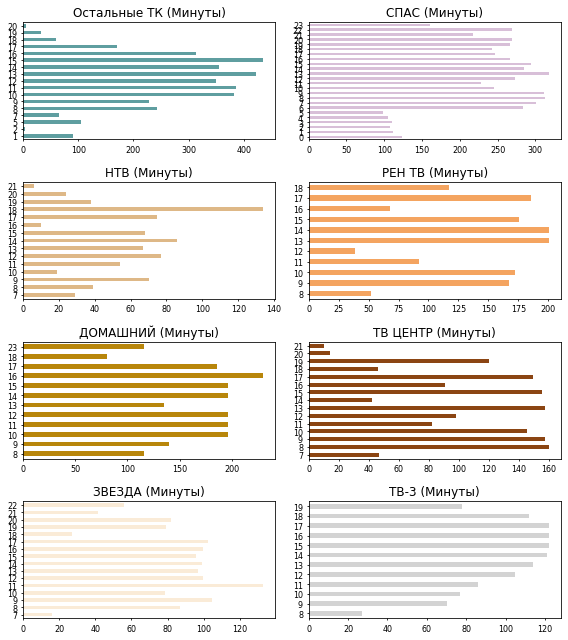

In [30]:
#Структурный график SEPARATE (гистограмма) 


def get_structure_bar_separate_TV (FileReport, structure_value, structure_parametr, week = None):
    def table_for_separate (channel):                                  #таблицу по разным рекламодателям
        table = FileReport[FileReport['Телеканалы']==channel]
        if week != None:
            table = table[table['Номер_недели']==week]
        else:
            table = table
        table = table.groupby(structure_parametr, dropna = False).sum()[structure_value]
        table = pd.DataFrame(table)
        if structure_parametr == 'День недели':                           #сортировка дней недели
            def_if_structure_parametr_den_nedeli_index (table)
        return table
    
    fig, ax = plt.subplots(4,2,figsize=(8,9))
    if structure_parametr ==  "Час_выхода" :
        figsize=(5,8)
        plt.subplots_adjust(wspace=1.2, hspace=0.2)
    elif structure_parametr == 'Длительность роликов (сек)':
        figsize=(5,8)
        plt.subplots_adjust(wspace=0.9, hspace=0.2)
    elif  structure_parametr == "Категория товара (сокр)" or structure_parametr =="Жанр_программы" :
        figsize = (6,9) 
        plt.subplots_adjust(wspace=0.9, hspace=0.3)
    else:
        figsize=(7,10)
        plt.subplots_adjust(wspace=0.6, hspace=0.3) 
        
     #для списка рекламодателей строим свою ось
    ax_list=(ax[0][0],ax[0][1],ax[1][0],ax[1][1],ax[2][0],ax[2][1],ax[3][0],ax[3][1])                        
    for i in range(0,len(FileReport['Телеканалы'].unique())):
        table = table_for_separate (label_list[i])
        table.plot(kind='barh',legend=False,ax=ax_list[i], title = ("{} ({})").format(label_list[i],structure_value),  color = colors_bar[i],\
                   sharey = False, sharex = False, width = 0.5, fontsize = 2)
        for ax in ax_list:
            ax.set_ylabel("")
            ax.tick_params(axis = 'y',  labelsize = 8,  length = 2) 
            ax.tick_params(axis = 'x',  labelsize = 8,  length = 2) 
          #ax.set_title(label_list[i],size = 8)
    plt.tight_layout()
    fig.savefig(f'TV_sep_bar_{structure_parametr}_{structure_value}_неделя{str(week)}.png',bbox_inches='tight') #сохранение
       

get_structure_bar_separate_TV(FileReport, 'Минуты', "Час_выхода"    )              #проверка
    

In [31]:
#Формирование html отчета


def form_html_report(FileReport, week_list, MONTH, parametr_for_report_dynamics_list,parametr_for_report_dynamics_list_FR, title_dynamics_list, title_dynamics_list_FR, definition_dynamics_list, definition_dynamics_list_FR,parametr_for_report_kol_list, parametr_for_report_kol_list_FR, title_kol_list, title_kol_list_FR, definition_kol_list, definition_kol_list_FR, parameter_for_structure_list, structure_value_list, title_structure_list):
    
    template = open(template_html, 'r')
    template_lines = template.read()                             
    template.close()
    position = template_lines.find('\n\n')                    

     
    dynamics = ''
    dynamics_FR = ""
    text_code = ''
    kolvo =''
    kolvo_FR =''
    structure = ""

    #страница с которой начинается печататься репорт
    stranitsa = 0                                     
    
    #for week in week_list:
    # динамические отчеты
    dynamics += '<h1>'
    dynamics += '<div class="top">\n'
    dynamics += '<img class="first" src="/content/mntdrive/My Drive/МК_report/logo.png">\n'     
    dynamics += f'<p>{stranitsa}</p>'
    #dynamics += f'<p></p>'
    dynamics += '<br><br><br><br><br><br>'
    dynamics += f'<m>Сводный динамический мониторинг <br><br> по Телеканалам </m>\n'
    dynamics += '</div>\n'
    dynamics += '</h1>'
    
    for parametr_for_report, title, definition in zip(parametr_for_report_dynamics_list, title_dynamics_list, definition_dynamics_list):   
        stranitsa += 1
        dynamics += '<h1></h1>\n'                             
        dynamics += '<div class="top">\n'
        dynamics += '<img class="first" src="/content/mntdrive/My Drive/МК_report/logo.png">\n'     
        dynamics += f'<p>{stranitsa}</p>'
        #dynamics +=f'<p></p>'
        dynamics += '</div>\n'
        dynamics += '<div class="tables">'
        dynamics += '<br>'
        dynamics += f'<h2>{str(title)} </h2>\n'
        if week == None:
            dynamics += f'<m> за {(MONTH)}</m>\n'
        else:
            dynamics += f'<m> за неделю {str(week)} ({(MONTH)})</m>\n'
        dynamics += '<br>'
        table, table_gr = get_dynamics_table_TV(FileReport, parametr_for_report, week = week)
        dynamics += table.to_html(classes="left_class") 
    
        get_lineplot_TV(FileReport, parametr_for_report, week  = week)
        dynamics += '<br><br>'
        dynamics += f'<img class="second" src="TV_plot_{parametr_for_report}_неделя{week}.png">'
        dynamics += '<br><br><br>'
        dynamics += f'<l>{str(definition)} </l>\n'
        dynamics += '</div>\n'
    
    # Динамические отчеты FR
# for week in week_list:
    for parametr_for_report, title, definition in zip(parametr_for_report_dynamics_list_FR, title_dynamics_list_FR, definition_dynamics_list_FR):    
        stranitsa += 1
            
        dynamics += '<h1></h1>\n'                              
        dynamics += '<div class="top">\n'
        dynamics += '<img class="first" src="/content/mntdrive/My Drive/МК_report/logo.png">\n'     
        dynamics += f'<p>{stranitsa}</p>'
        #dynamics += f'<p></p>'
        dynamics += '</div>\n'
        
        dynamics += '<div class="tables">'
        dynamics += '<br>'
        dynamics += f'<h2>{str(title)} </h2>\n'
        if week == None:
            dynamics += f'<m> за {(MONTH)}</m>\n'
        else:
            dynamics += f'<m> за неделю {str(week)} ({(MONTH)})</m>\n'
        dynamics += '<br>'
        table, table_gr  = get_dynamics_table_FR_TV(FileReport_fr, parametr_for_report, week = week)
        dynamics+= table.to_html(classes="left_class") 
    
        get_lineplot_FR_TV(FileReport_fr, parametr_for_report, week  = week)
        dynamics += '<br><br>'
        dynamics += f'<img class="second" src="TV_FRplot_{parametr_for_report}_неделя{str(week)}.png">'
        dynamics += '<br><br><br>'
        dynamics += f'<l>{str(definition)} </l>\n'
        dynamics += '</div>\n'
      
    #количественные отчеты
    stranitsa += 1  
    kolvo += '<h1>'
    kolvo += '<div class="top">\n'
    kolvo += '<img class="first" src="/content/mntdrive/My Drive/МК_report/logo.png">\n'     
    kolvo += f'<p>{stranitsa}</p>'
    #kolvo += f'<p></p>'
    kolvo += '<br><br><br><br><br><br>'
    kolvo += f'<m>Сводный количественный мониторинг <br><br> по Телеканалам </m>\n'
    kolvo += '</div>\n'
    kolvo += '</h1>'
# for week in week_list:
    for parametr_for_report, title, definition in zip(parametr_for_report_kol_list, title_kol_list, definition_kol_list):    
        stranitsa += 1         
        kolvo += '<h1></h1>\n'
        kolvo += '<div class="top">\n'
        kolvo += '<img class="first" src="/content/mntdrive/My Drive/МК_report/logo.png">\n'
        kolvo += f'<p>{stranitsa}</p>'
        #kolvo += f'<p></p>'
        kolvo += '</div>\n'
                    
        kolvo += '<div class="tables">'
        kolvo += '<br>'
        kolvo += f'<h2>{str(title)} </h2>\n'
        if week != None:
            kolvo += f'<m> за неделю {str(week)} ({(MONTH)})</m>\n'
        else:
            kolvo += f'<m> за {(MONTH)}</m>\n'
        kolvo += '<br><br>'
        table = get_kolichestvo_table_html_TV (FileReport, parametr_for_report, week = week)
        kolvo += table.to_html()
                
        get_pie_TV (FileReport, parametr_for_report, week  = week)
        kolvo += '<br><br>'
        kolvo += f'<img class="second" src="TV_pie_{parametr_for_report}_неделя{str(week)}.png">'
        kolvo += '<br><br><br>'
        kolvo += f'<l>{str(definition)} </l>\n'
        kolvo += '</div>\n'

        #количественные FR
#for week in week_list:
    for parametr_for_report, title, definition in zip(parametr_for_report_kol_list_FR, title_kol_list_FR, definition_kol_list_FR):    
        stranitsa += 1         
        kolvo += '<h1></h1>\n'
        kolvo += '<div class="top">\n'
        kolvo += '<img class="first" src="/content/mntdrive/My Drive/МК_report/logo.png">\n'
        kolvo += f'<p>{stranitsa}</p>'
        #kolvo += f'<p></p>'
        kolvo += '</div>\n'
                    
        kolvo += '<div class="tables">'
        kolvo += '<br>'
        kolvo += f'<h2>{str(title)} </h2>\n'
        if week != None:
            kolvo += f'<m> за неделю {str(week)} ({(MONTH)})</m>\n'
        else:
            kolvo += f'<m> за {(MONTH)}</m>\n'
        kolvo += '<br><br>'
        table = get_kolichestvo_table_html_FR_TV (FileReport_fr, parametr_for_report, week = week)
        kolvo += table.to_html()
                
        get_pie_FR_TV (FileReport_fr, parametr_for_report, week  = week)
        kolvo += '<br><br>'
        kolvo += f'<img class="second" src="TV_FRpie_{parametr_for_report}_неделя{str(week)}.png">'
        kolvo += '<br><br><br>'
        kolvo += f'<l>{str(definition)} </l>\n'
        kolvo += '</div>\n'

#структурные отчеты
    structure += '<h1>'
    structure += '<div class="top">\n'
    structure += '<img class="first" src="/content/mntdrive/My Drive/МК_report/logo.png">\n'     
    structure += f'<p>{stranitsa}</p>'
    #structure += f'<p></p>'
    structure += '<br><br><br><br><br><br>'
    structure += f'<m>Сводный структурный мониторинг <br><br> по Телеканалам </m>\n'
    structure += '</div>\n'
    structure += '</h1>'

#for week in week_list:
    for structure_parametr, structure_value, title_structure in zip (parameter_for_structure_list, structure_value_list, title_structure_list):    
        stranitsa += 1
        
        structure += '<h1></h1>\n'
        structure += '<div class="top">\n'
        structure += '<img class="first" src="/content/mntdrive/My Drive/МК_report/logo.png">\n'
        structure += f'<p>{stranitsa}</p>'
        #structure += f'<p></p>'
        structure += '</div>\n'
        
        structure += '<div class="tables">'
        structure += '<br>'
        structure += f'<h2>{str(title_structure)} ({structure_value}) </h2>\n'
        if week != None:
            structure += f'<m> за неделю {str(week)} ({MONTH})</m>\n'
        else:
            structure += f'<m> за {MONTH}</m>\n'
        structure += '<br><br><br>'
        table = get_structure_table_TV (FileReport, structure_value, structure_parametr, week = week)
        structure += table.to_html(classes="left_class")   #отдельный класс чтобы выравнивание слева
        if structure_parametr == '':
            structure += '<br>'
            get_structure_bar_TV  (FileReport, structure_value, structure_parametr, week = week)
            structure += f'<img class="second" src= "TV_bar_{structure_parametr}_{structure_value}_неделя{str(week)}.png">'
        else:               
            #stranitsa += 1    #страница с графиком общим
            structure += '<h1></h1>\n'
            structure += '<div class="top">\n'
            structure += '<img class="first" src="/content/mntdrive/My Drive/МК_report/logo.png">\n'
            structure += f'<p>{stranitsa}</p>'
            #structure += f'<p></p>'
            structure += '<br><br><br>'
            get_structure_bar_TV  (FileReport, structure_value, structure_parametr, week = week)
            structure += f'<img class="second" src= "TV_bar_{structure_parametr}_{structure_value}_неделя{str(week)}.png">'
                
        stranitsa += 1   #таблица с графиком отдельным
        structure += '<h1></h1>\n'
        structure += '<div class="top">\n'
        structure += '<img class="first" src="/content/mntdrive/My Drive/МК_report/logo.png">\n'
        structure += f'<p>{stranitsa}</p>'
        #structure += f'<p></p>'
        structure += '</div>\n'
        structure += '<div class="tables">'
        structure += '<br><br><br>'
        get_structure_bar_separate_TV (FileReport, structure_value, structure_parametr, week = week)
        structure += f'<img class="second" src="TV_sep_bar_{structure_parametr}_{structure_value}_неделя{str(week)}.png">'
        structure += '</div>\n'
    
    #создание единого файла     
    new_lines  = template_lines[0:position+1] + text_code + template_lines[position + 2:]
    new_lines1 = template_lines[0:position+1] + dynamics + template_lines[position + 2:]
    new_lines2 = template_lines[0:position+1] + kolvo + template_lines[position + 2:]
    new_lines3 = template_lines[0:position+1] + structure + template_lines[position + 2:]

    # объединение и сохранение в файл html
    new_lines = new_lines + new_lines1 + new_lines2 + new_lines3 
    new_file = open(html_file, 'w+')
    new_file.write(new_lines)
    new_file.close()



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are

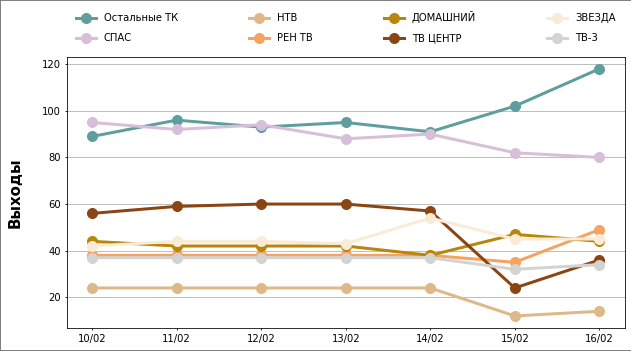

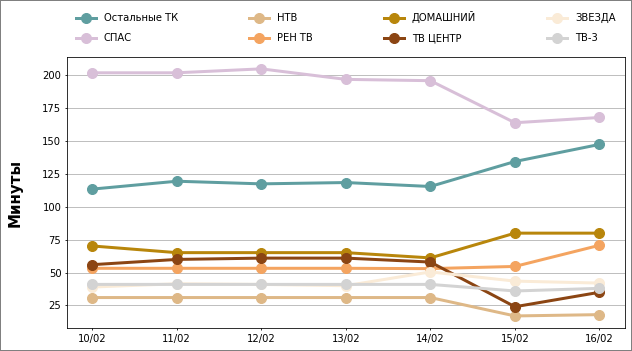

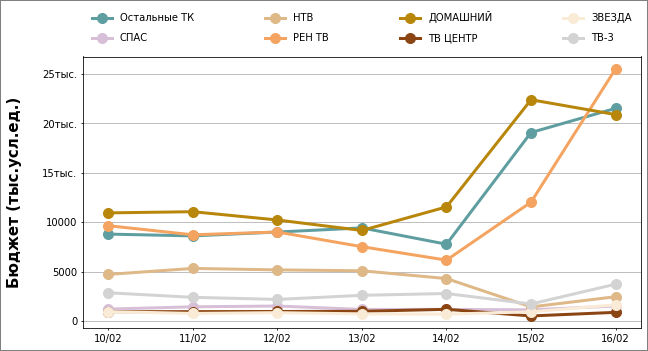

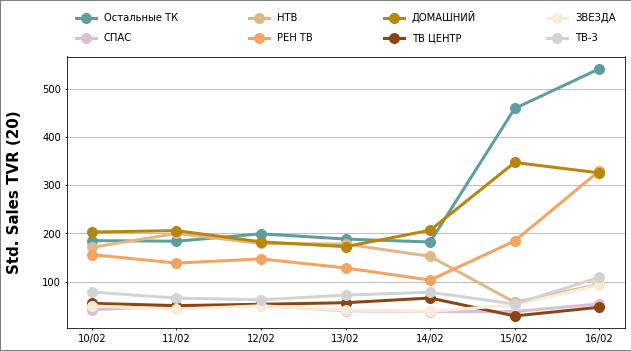

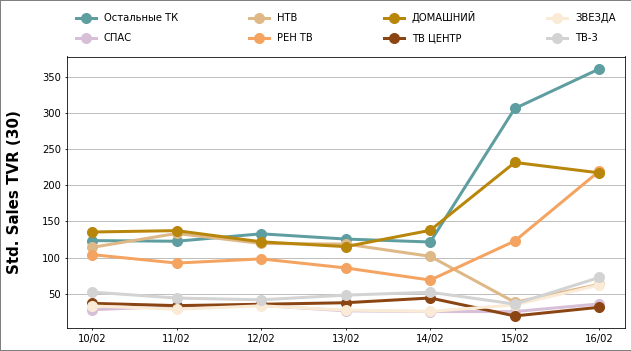

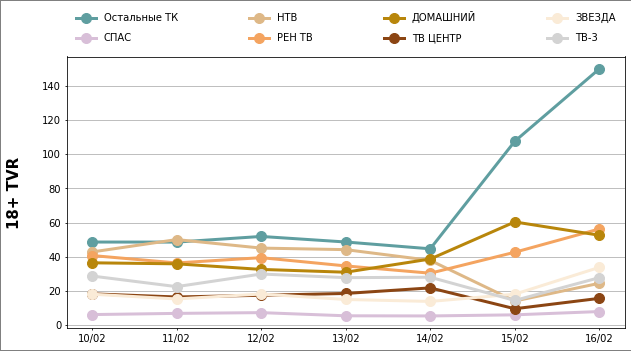

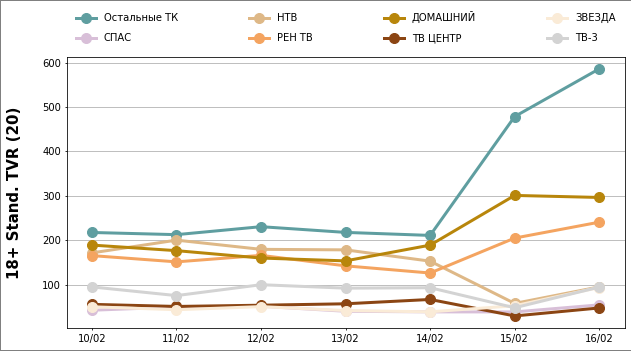

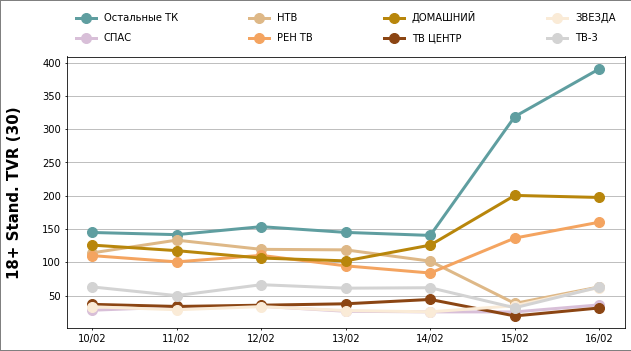

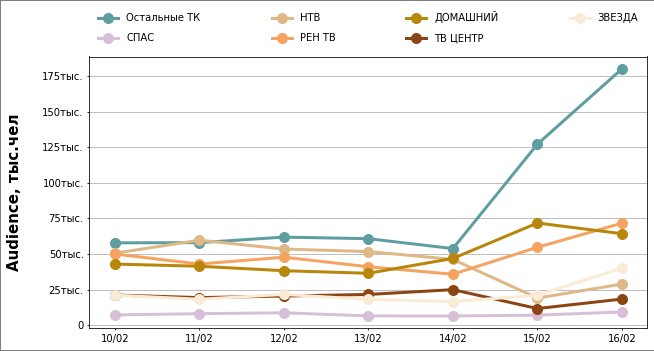

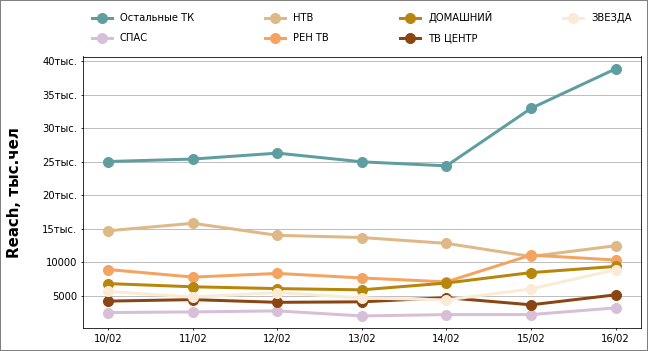

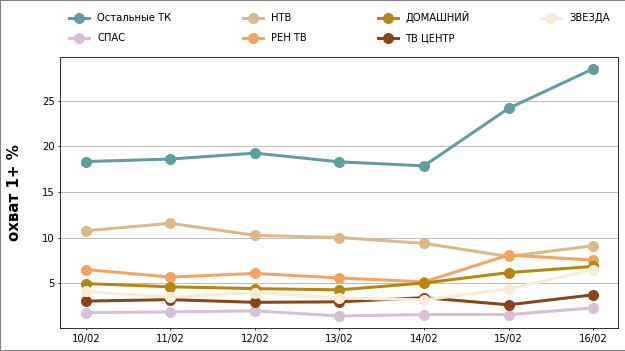

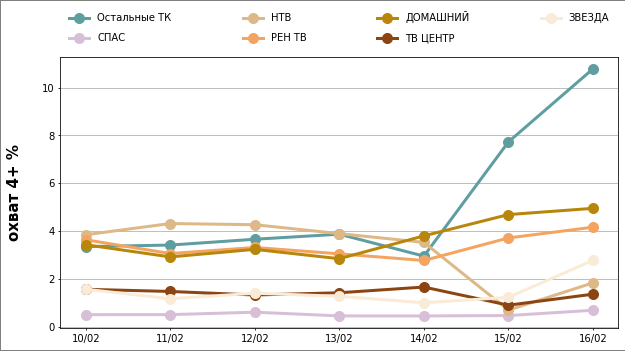

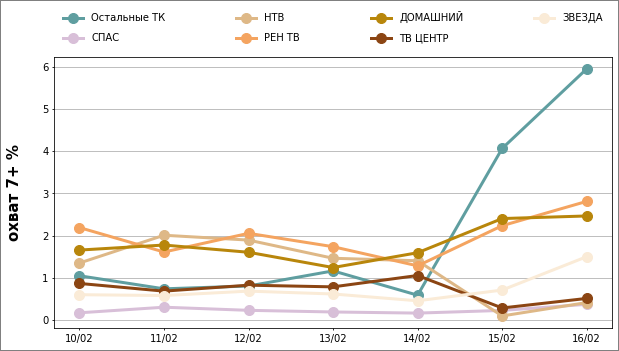

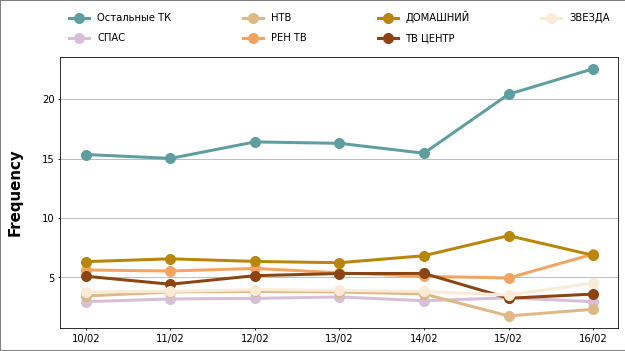

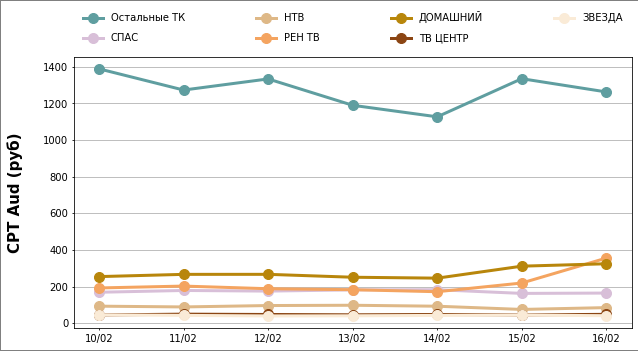

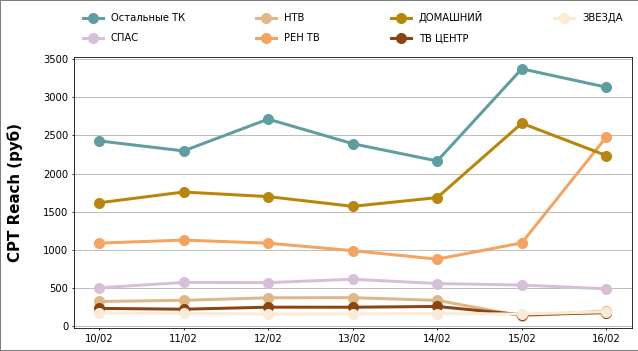

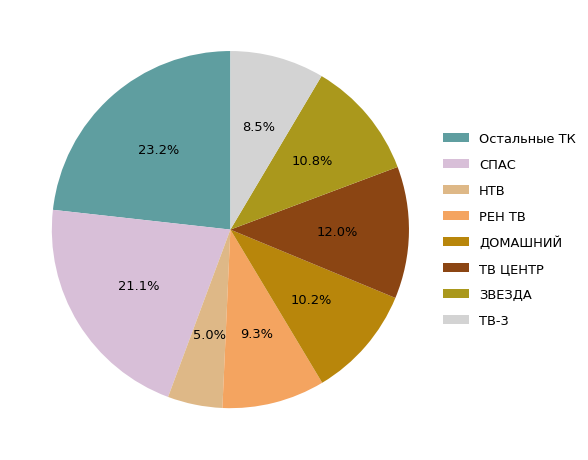

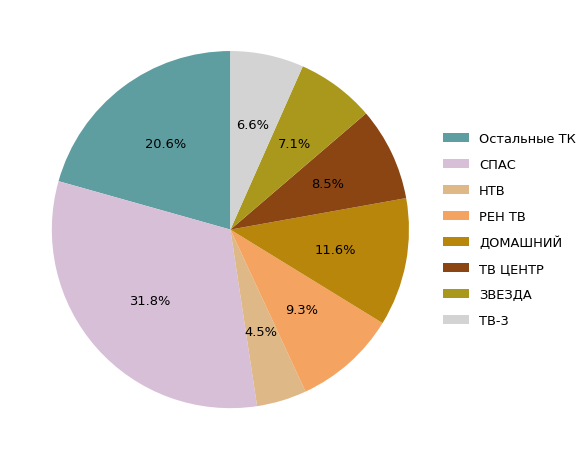

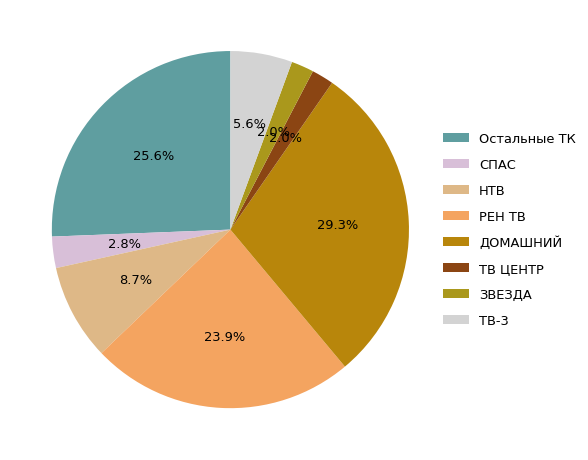

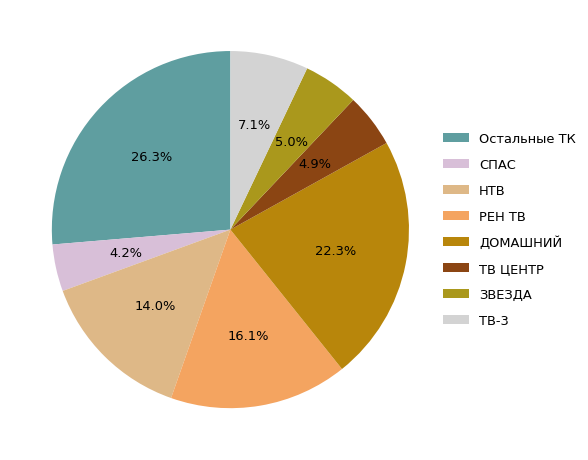

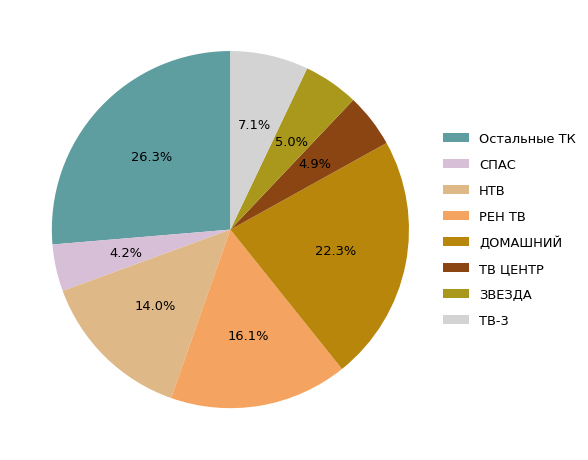

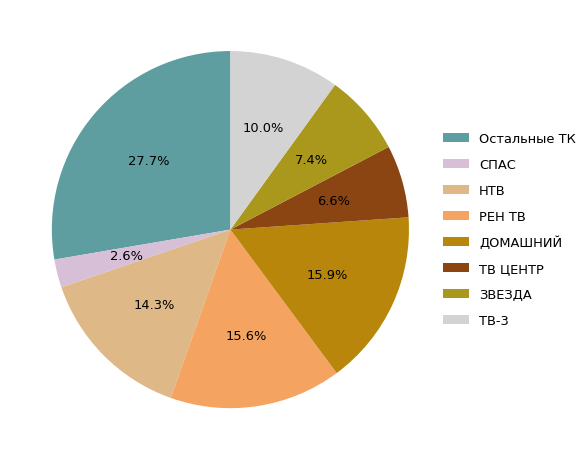

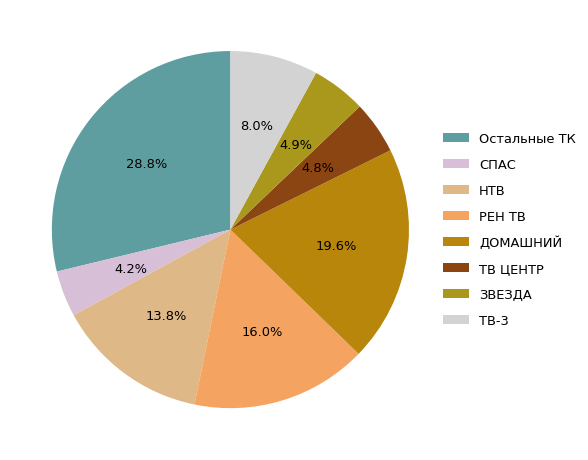

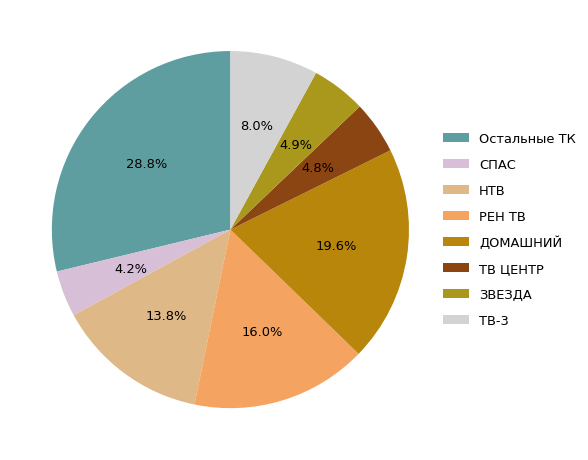

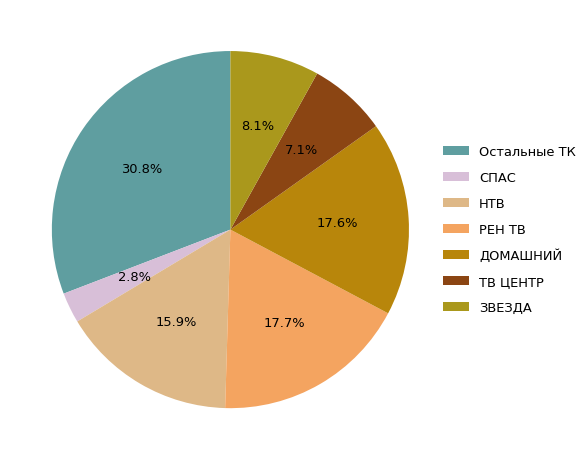

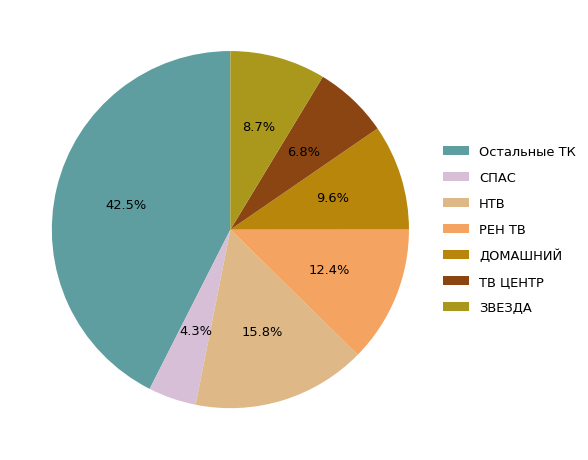

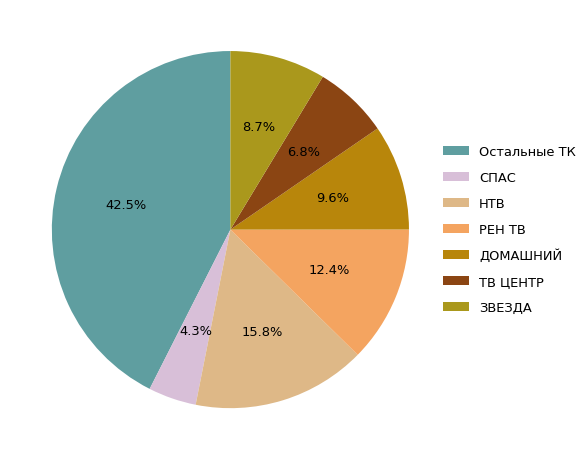

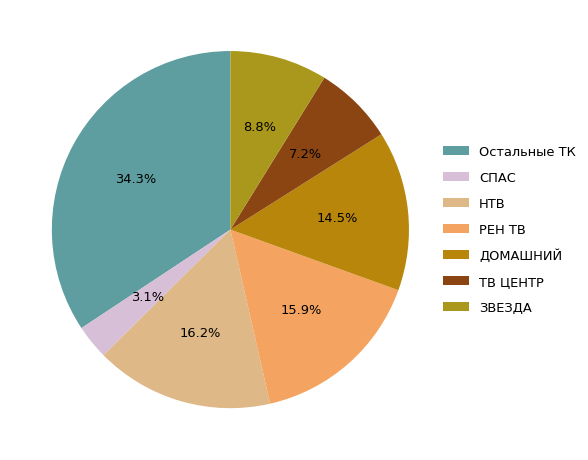

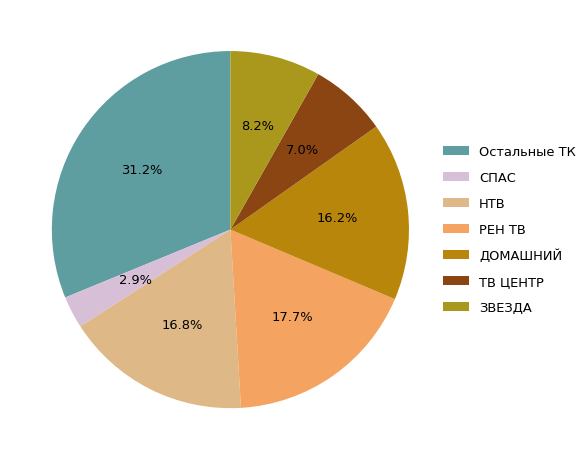

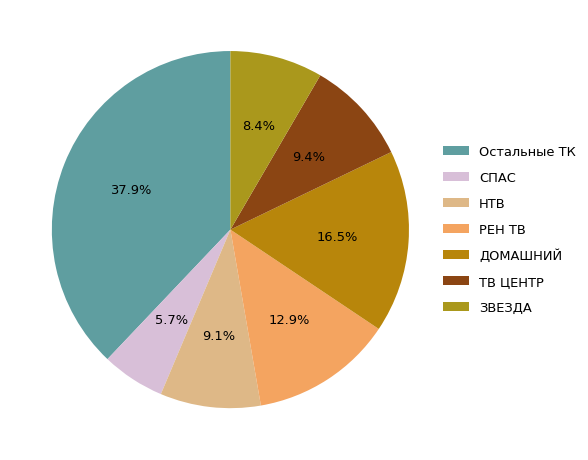

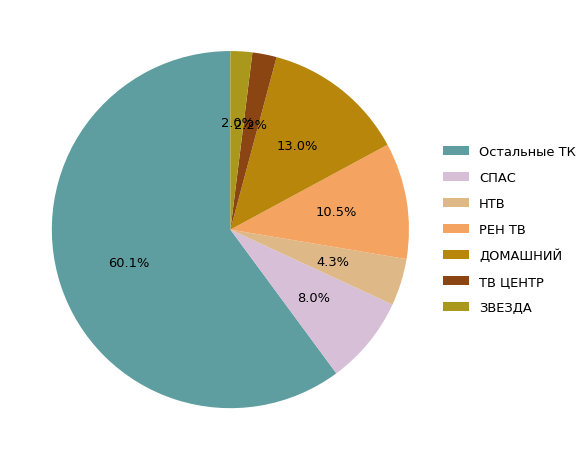

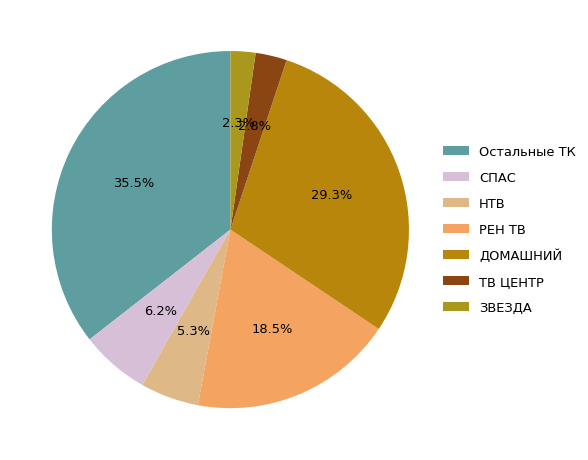

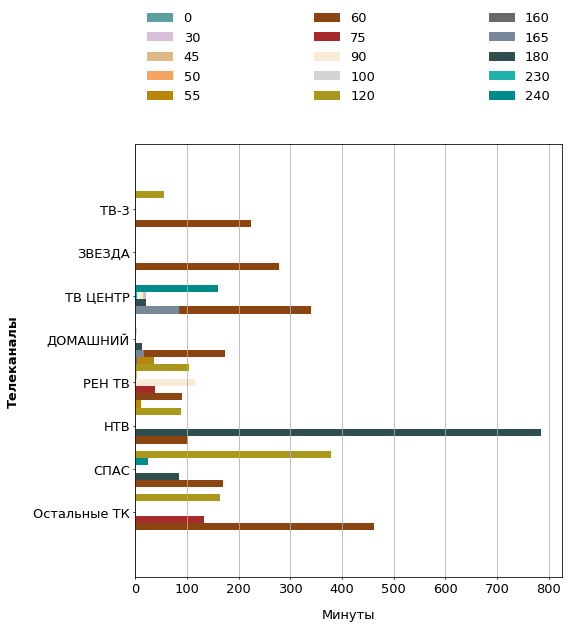

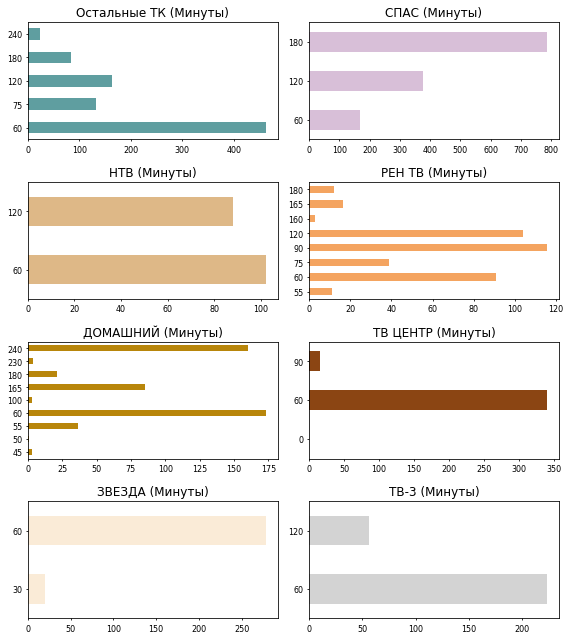

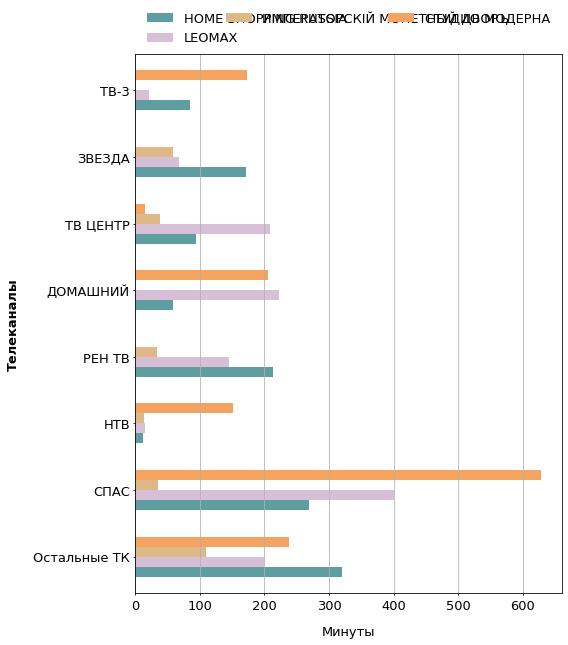

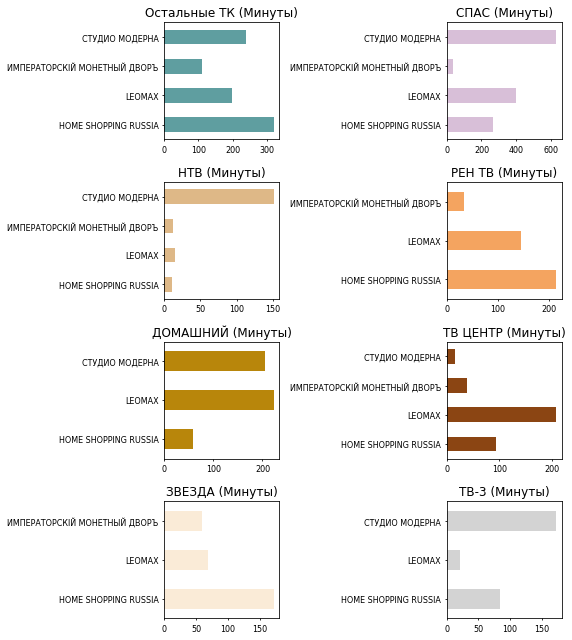

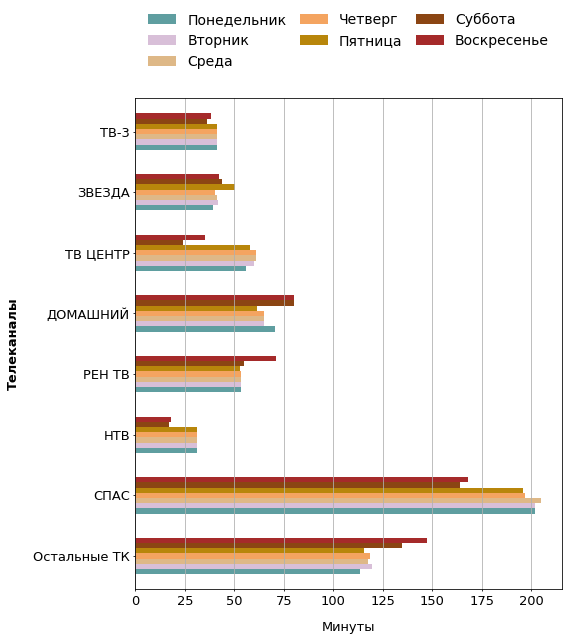

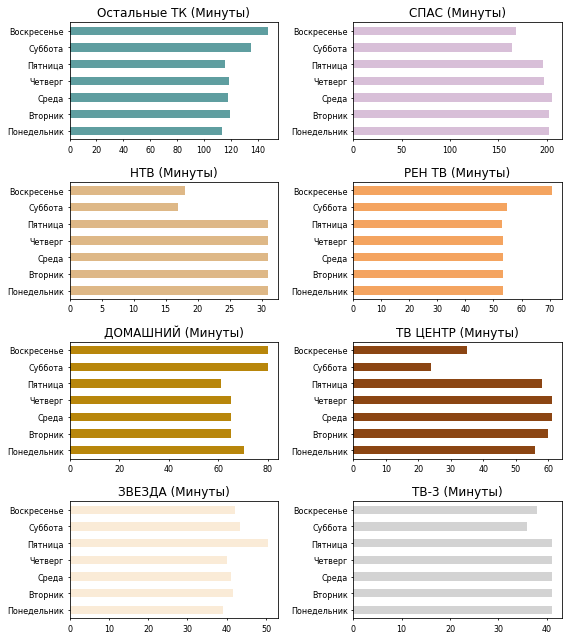

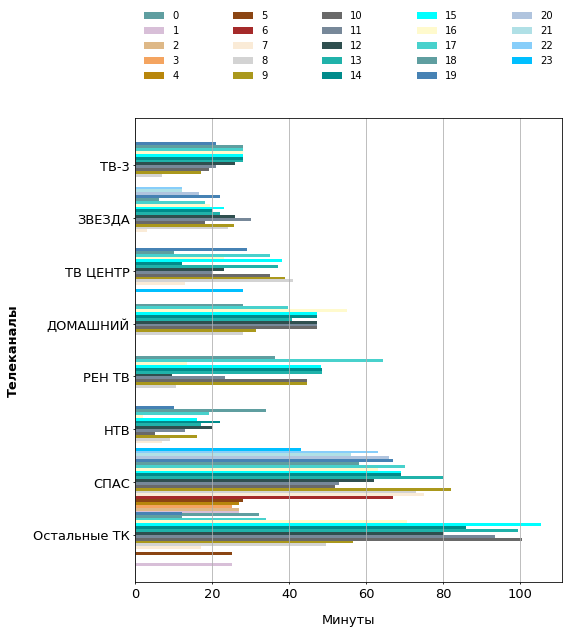

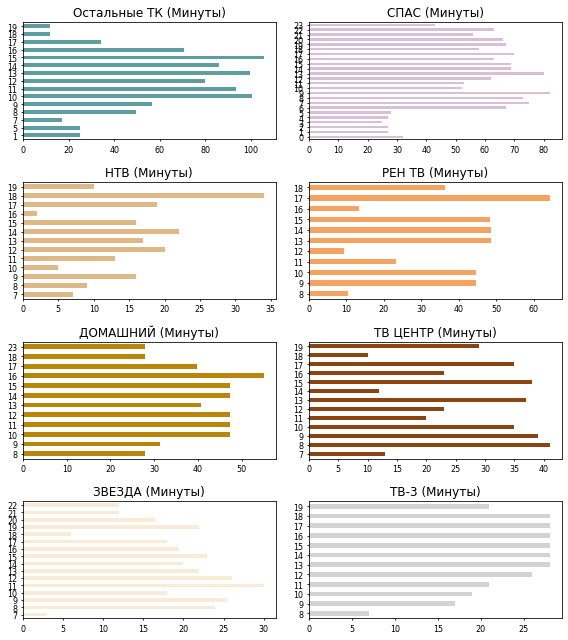

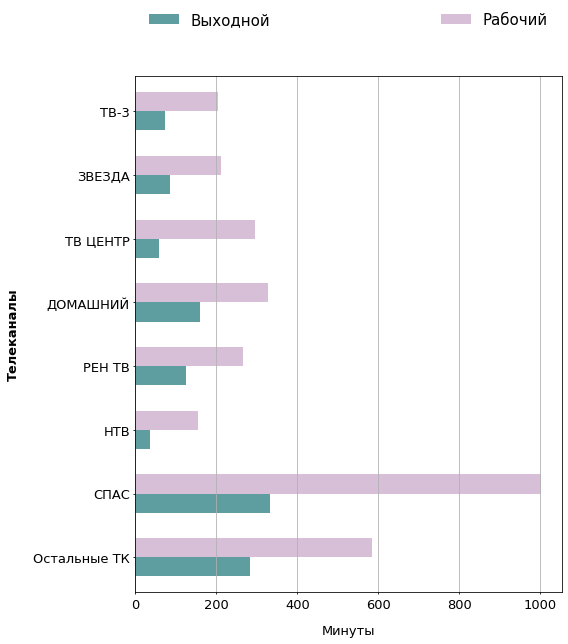

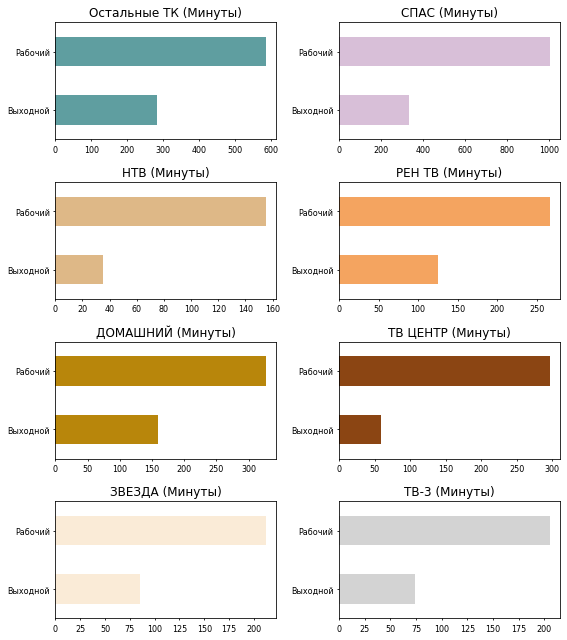

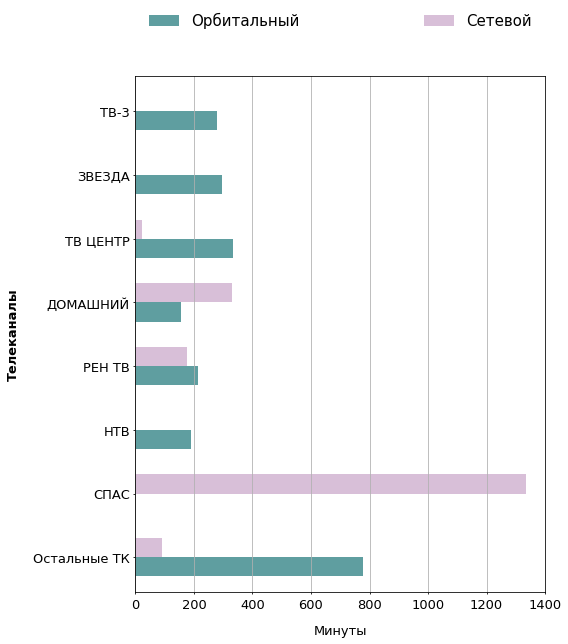

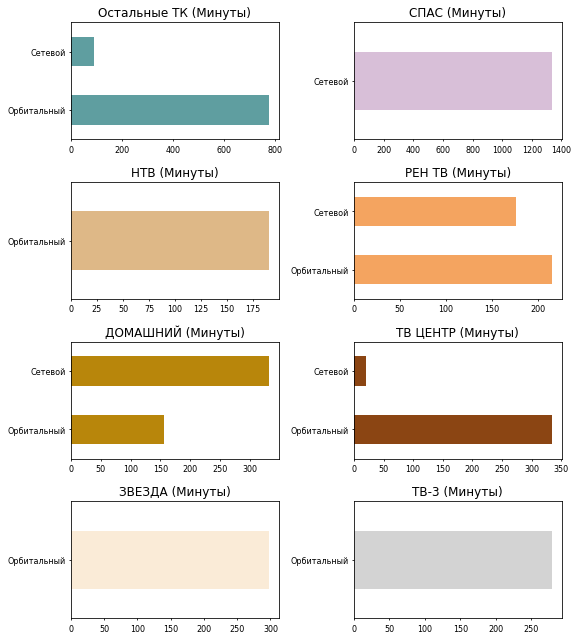

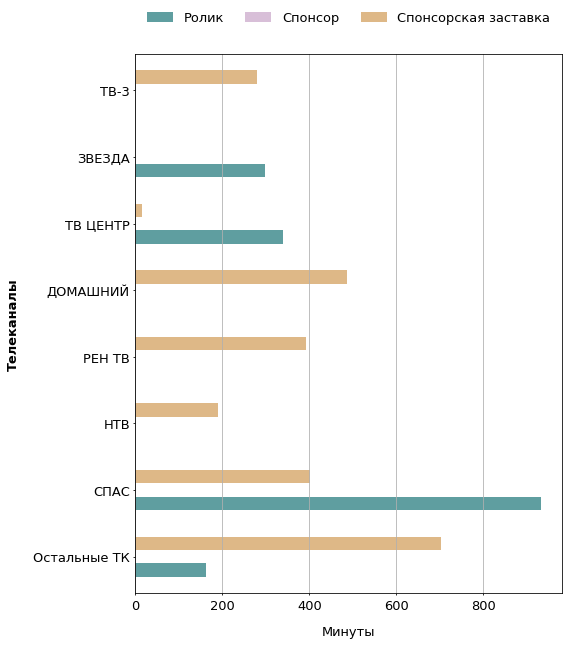

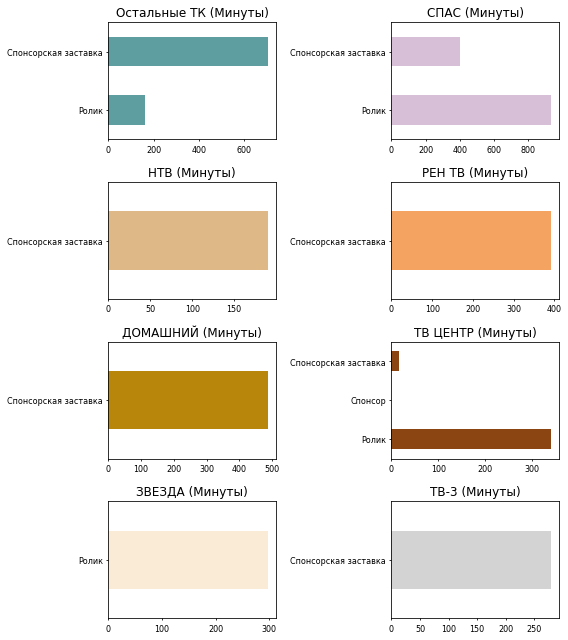

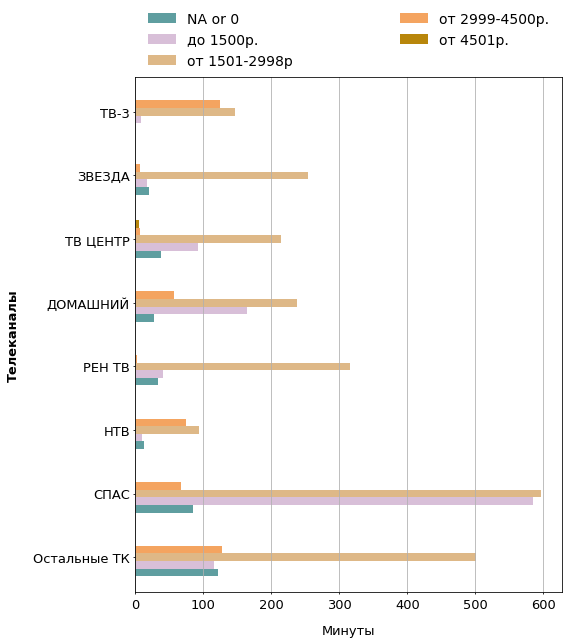

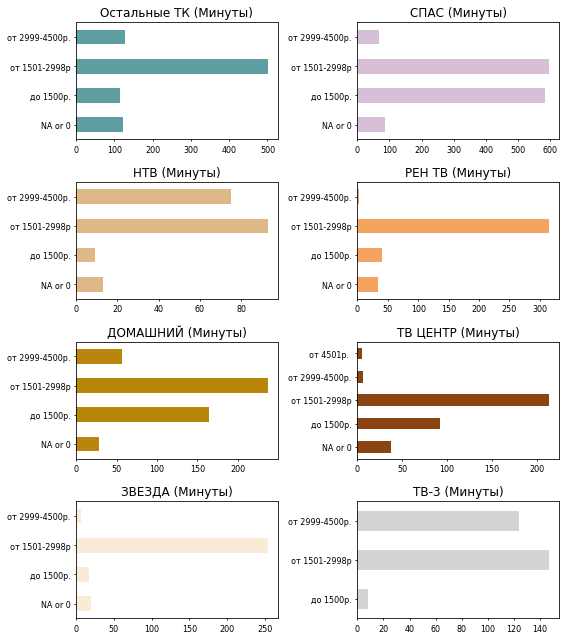

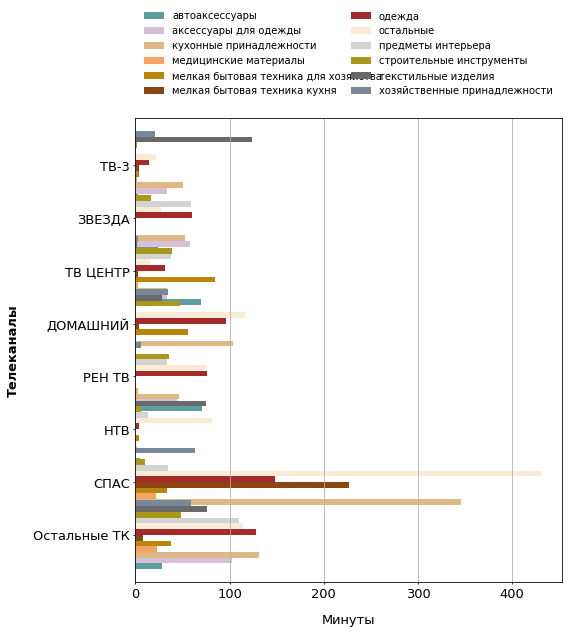

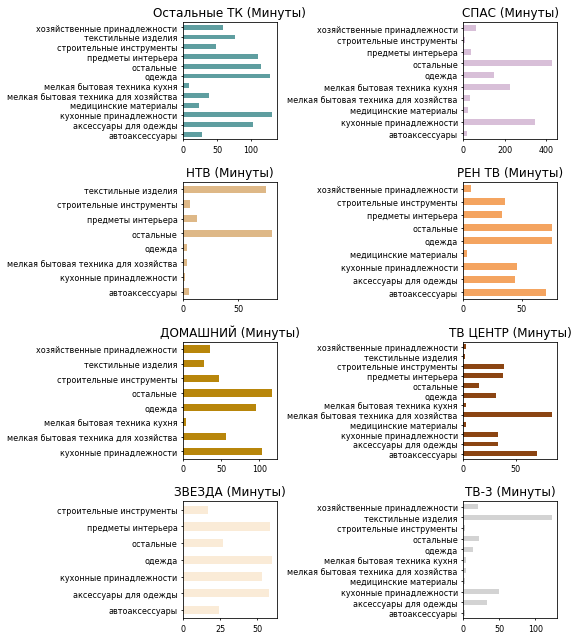

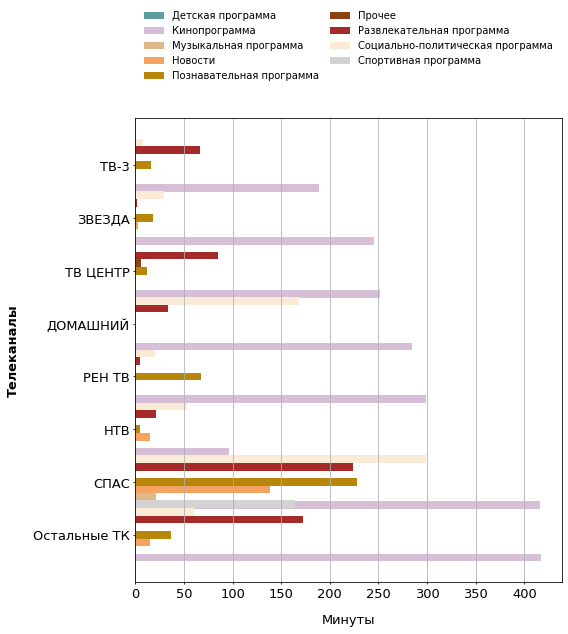

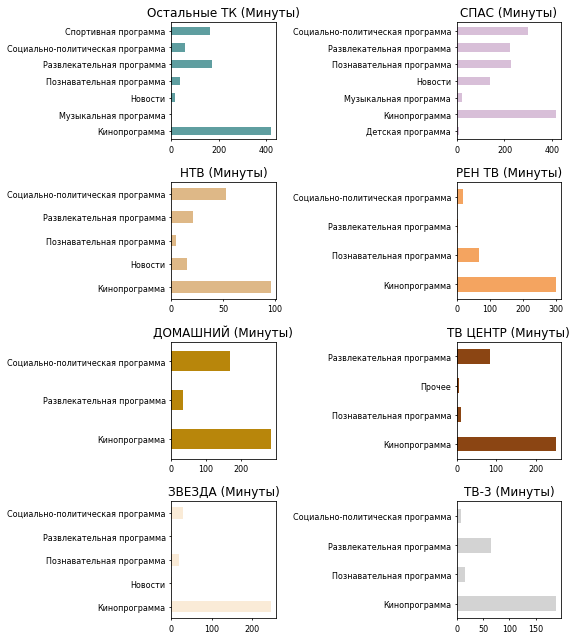

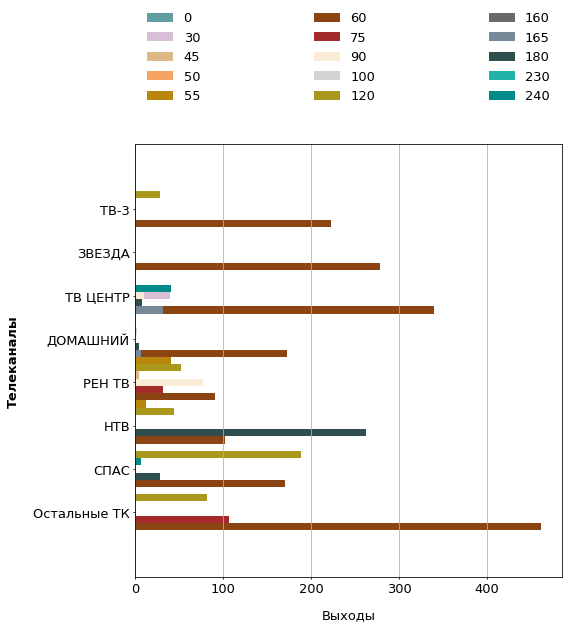

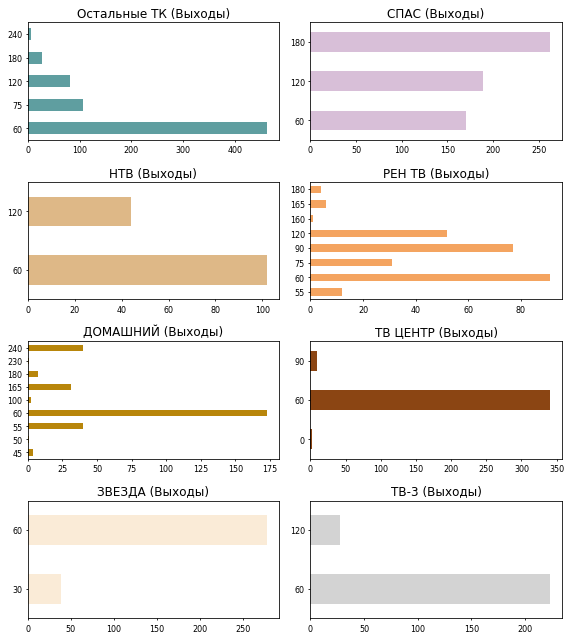

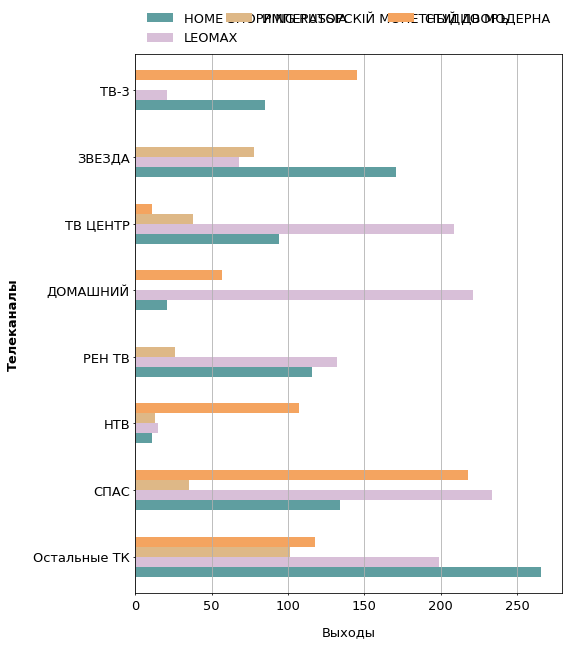

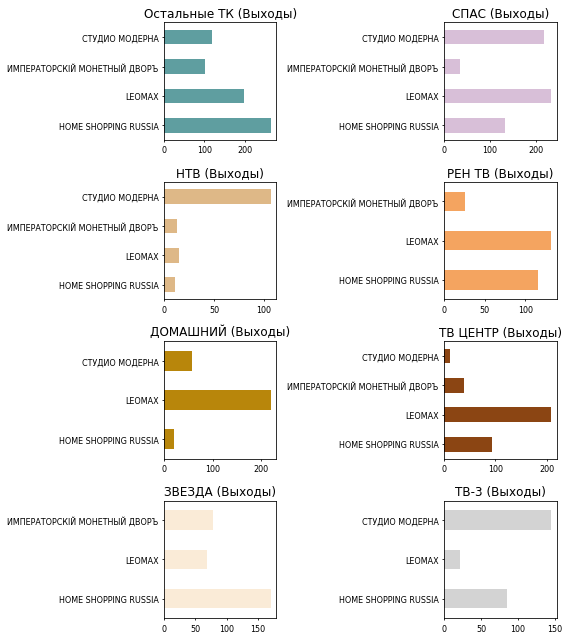

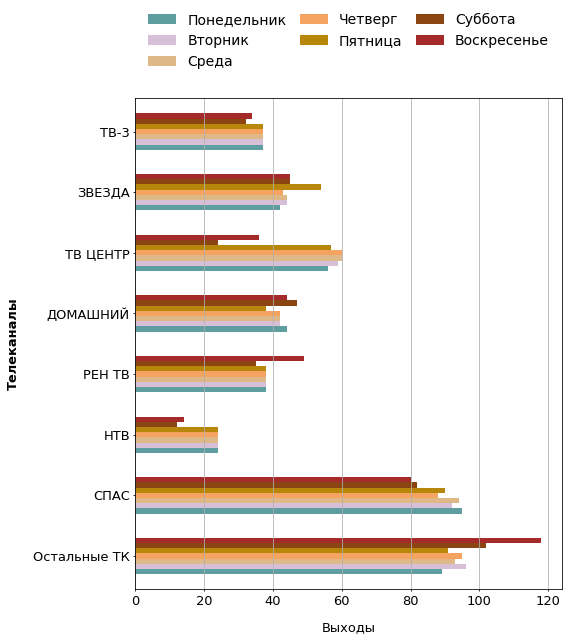

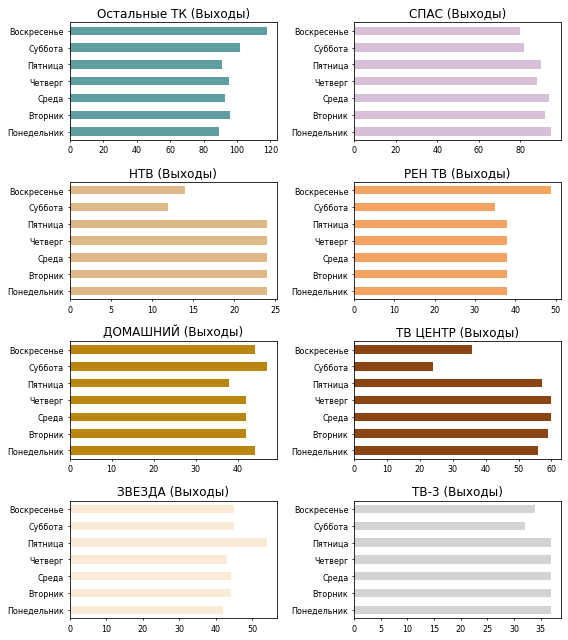

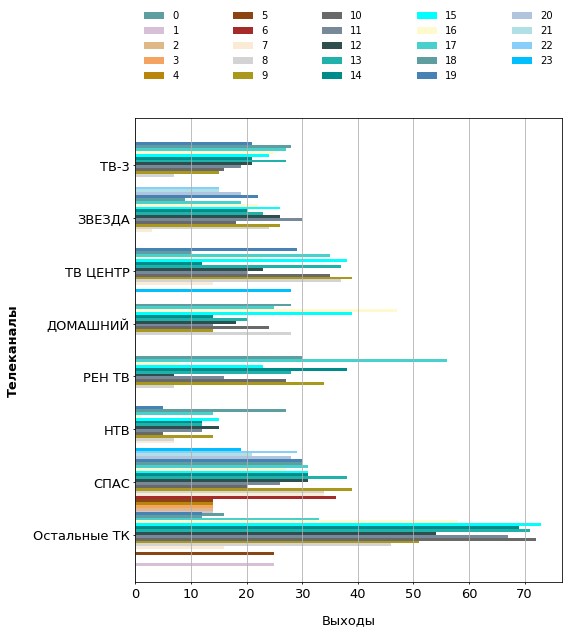

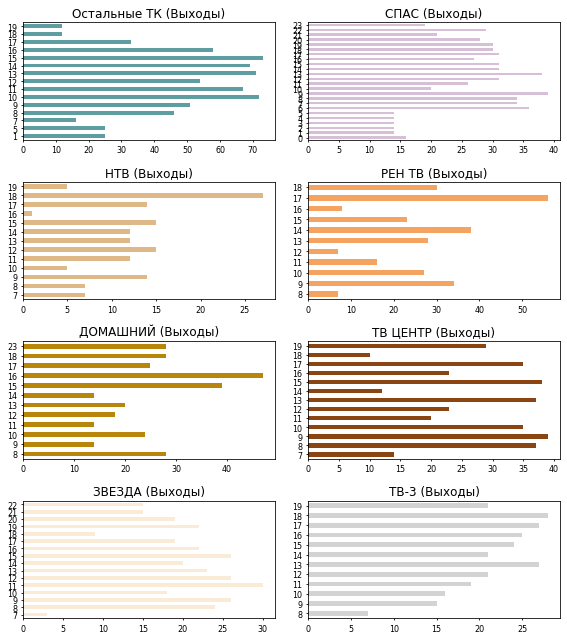

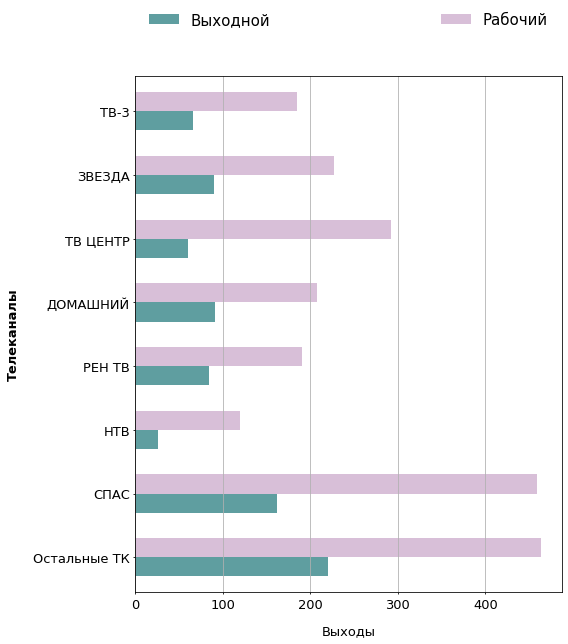

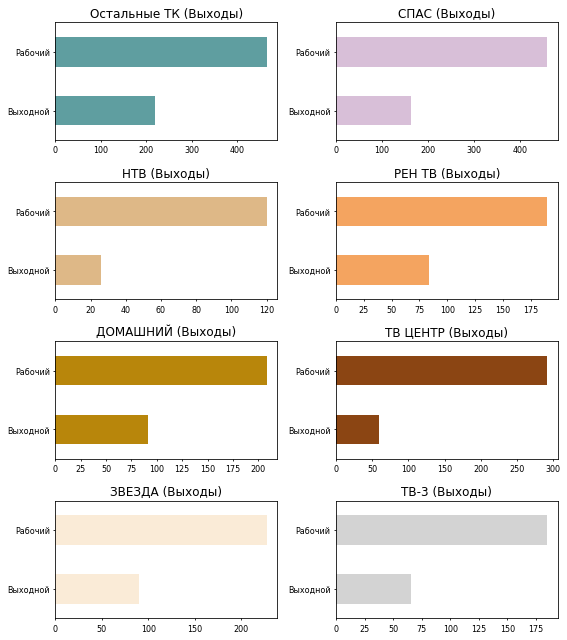

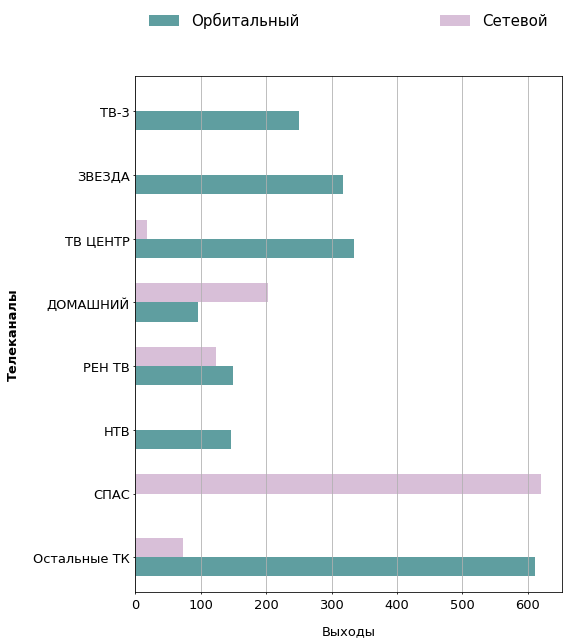

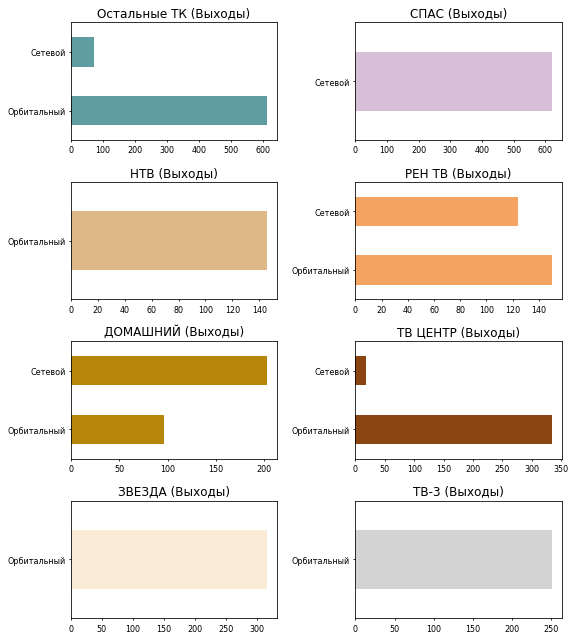

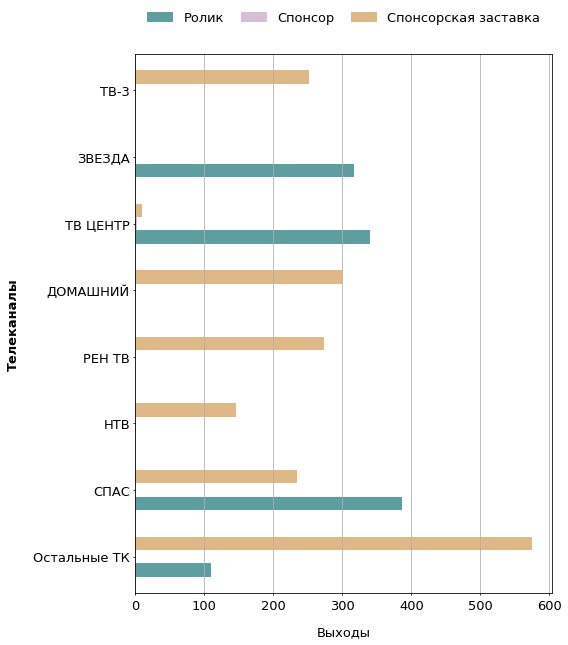

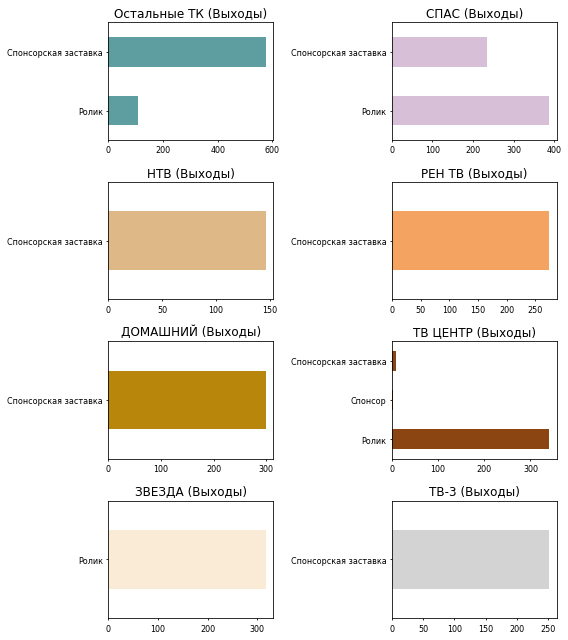

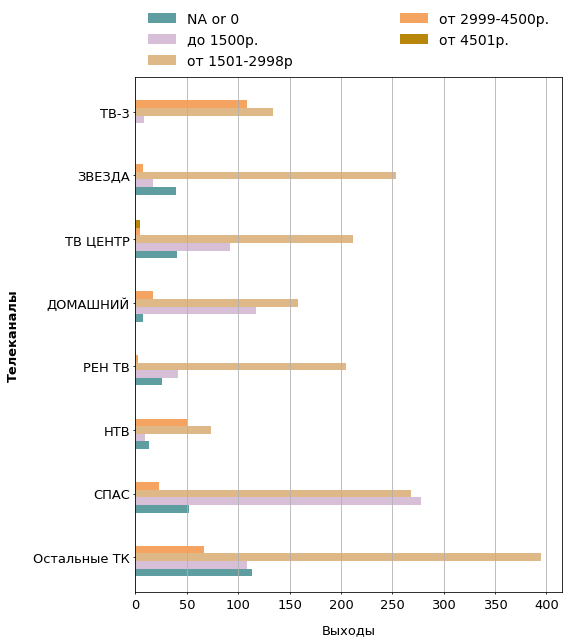

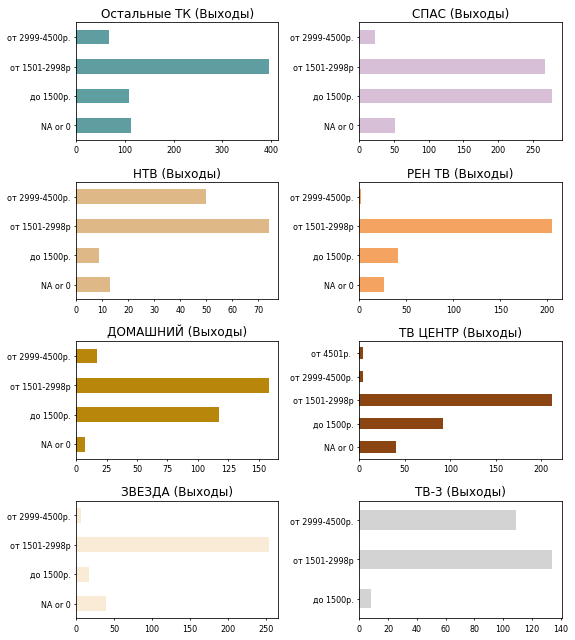

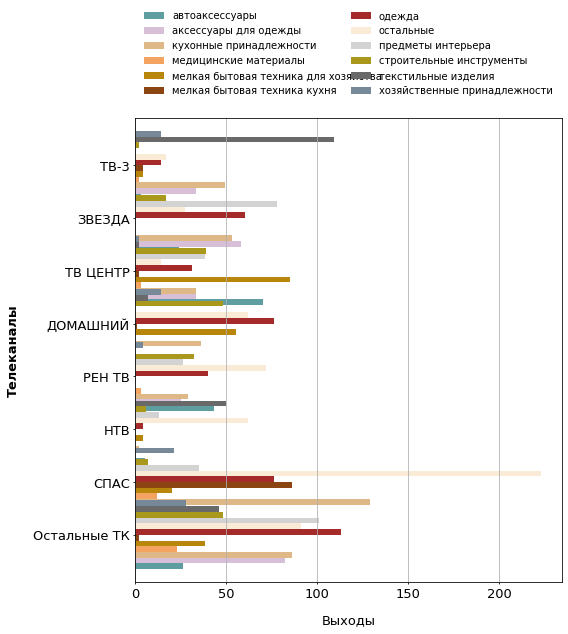

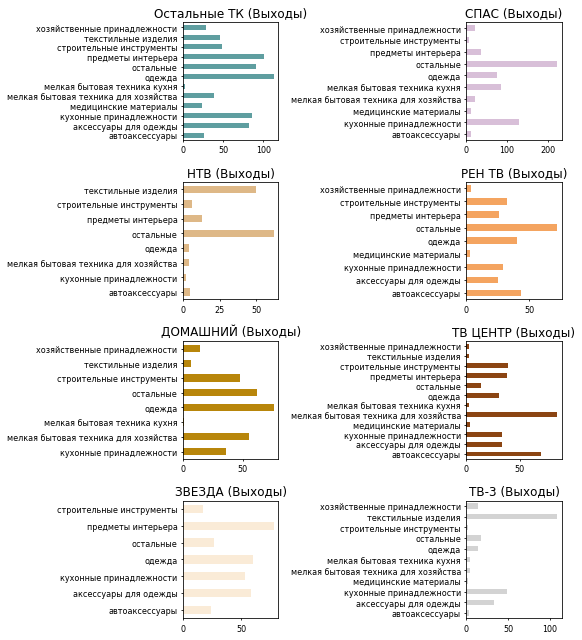

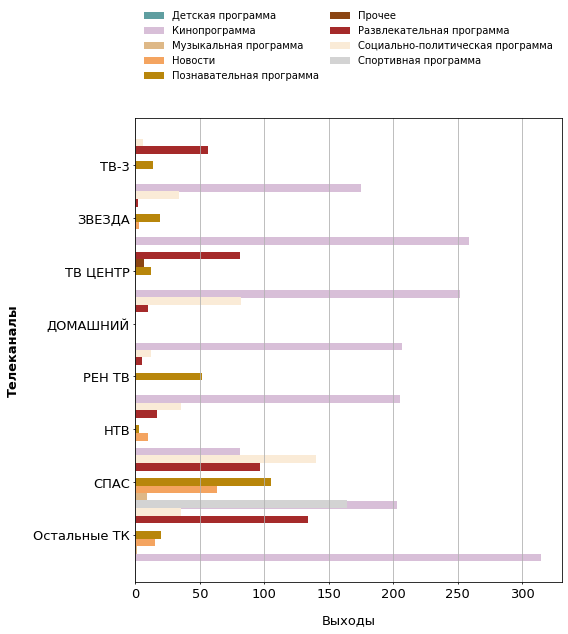

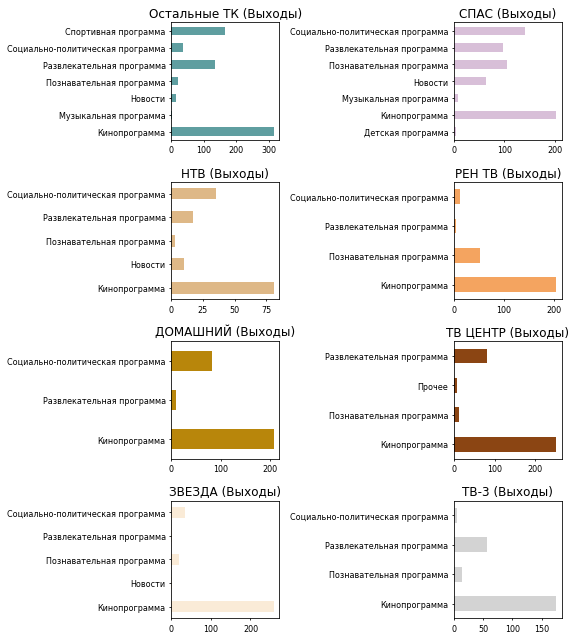

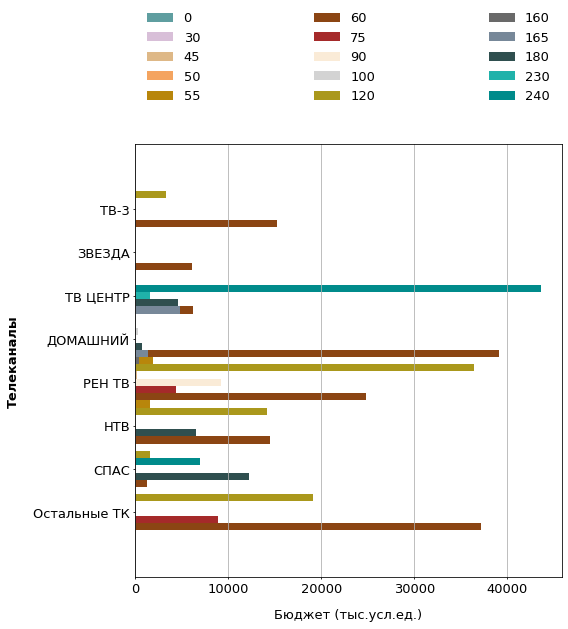

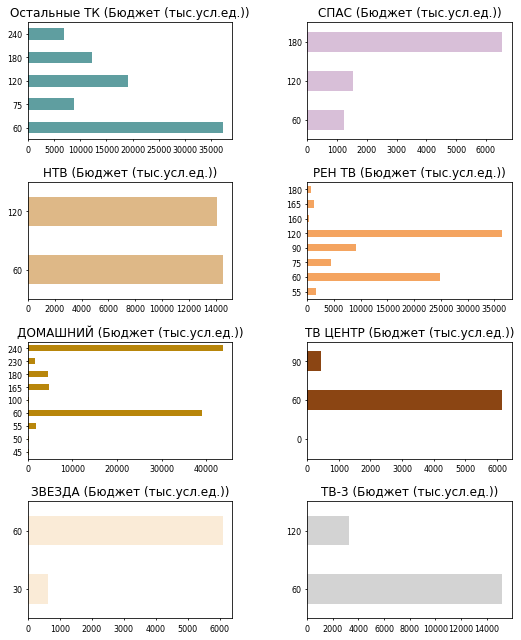

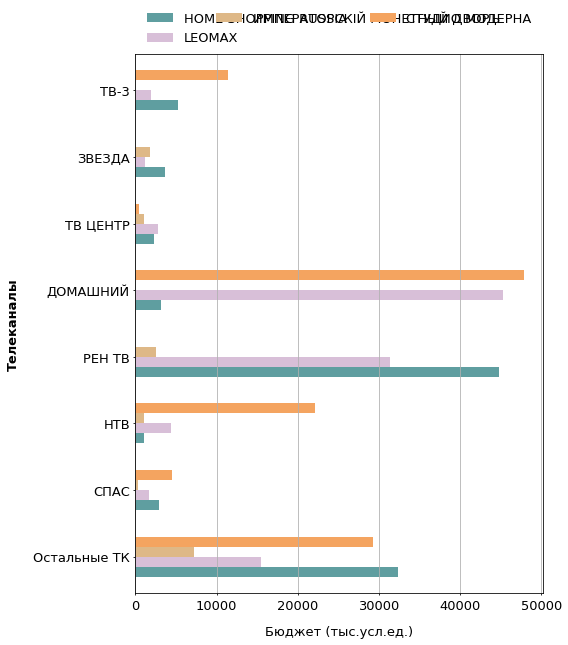

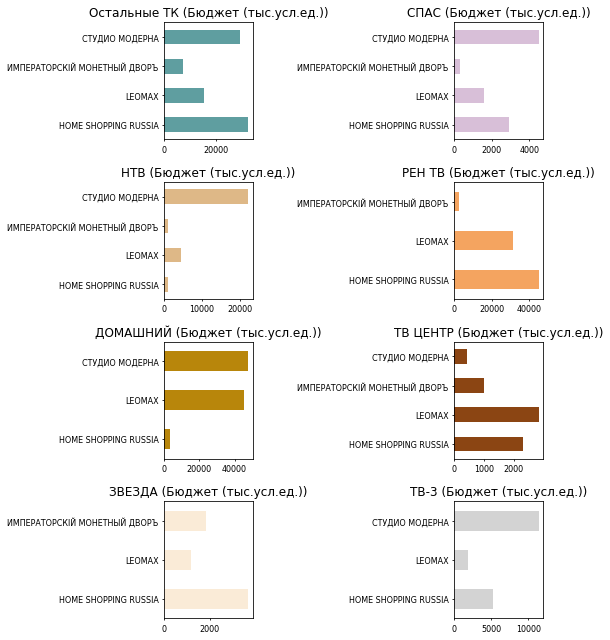

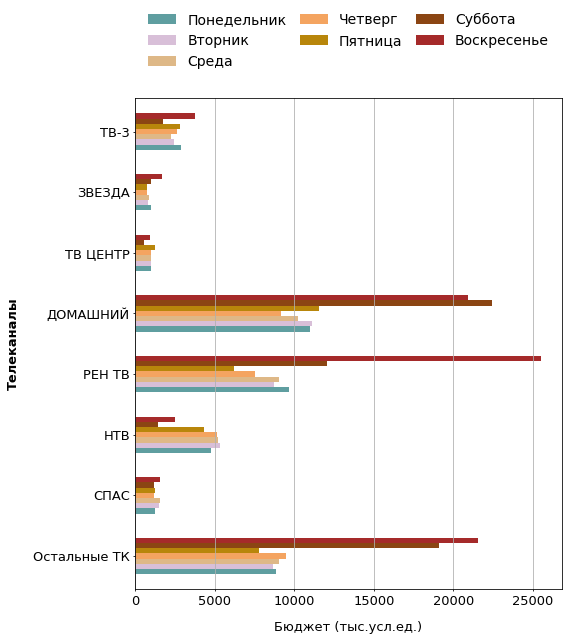

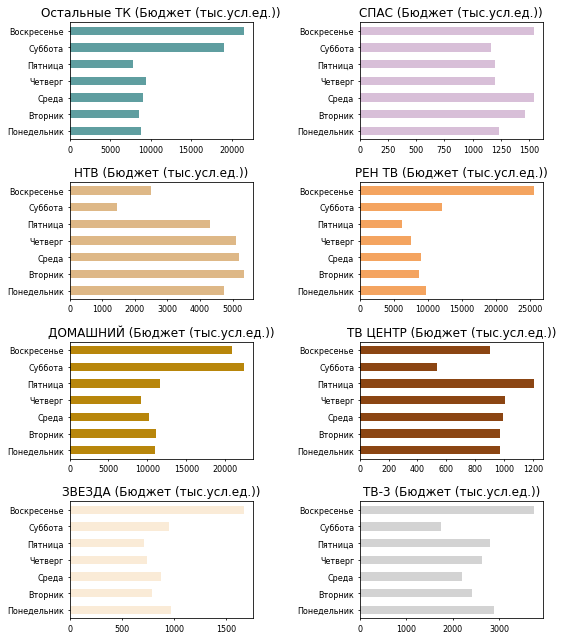

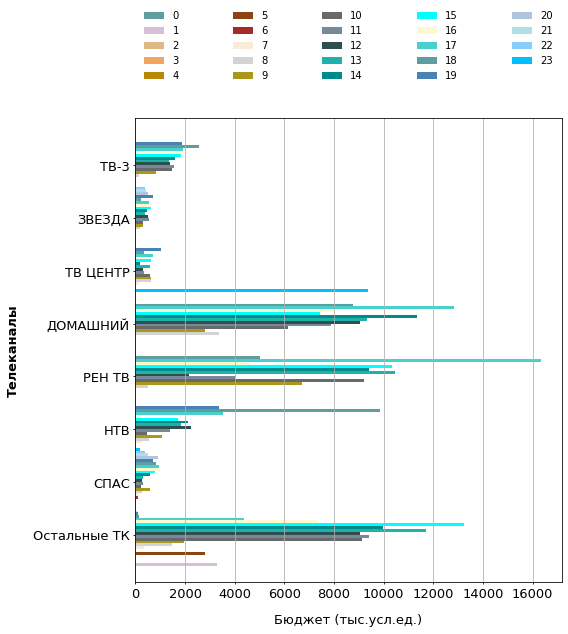

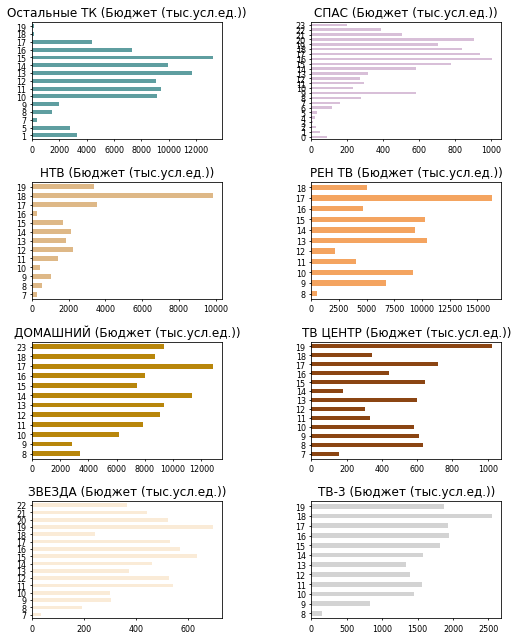

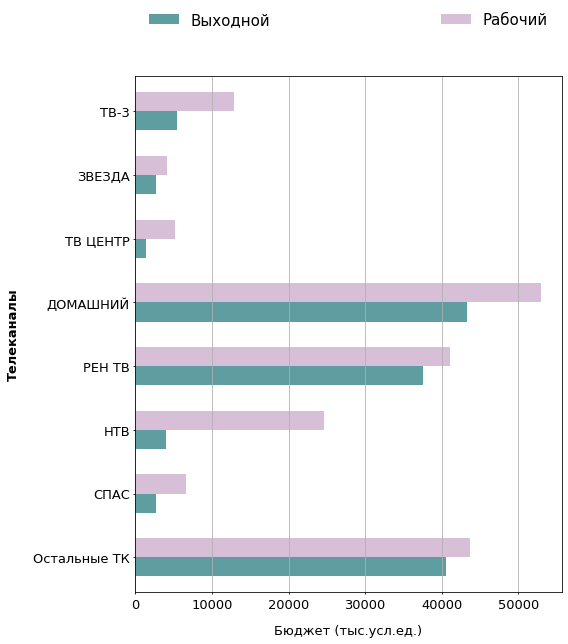

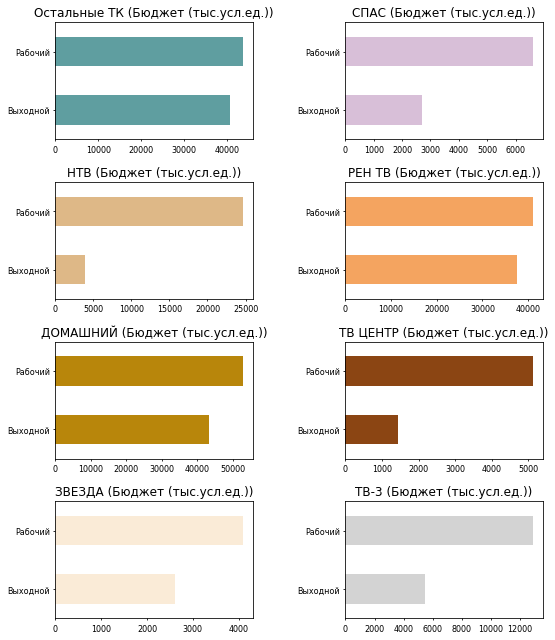

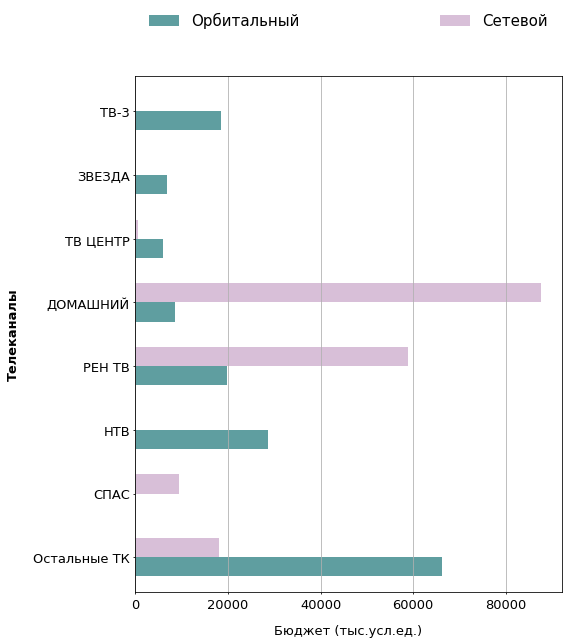

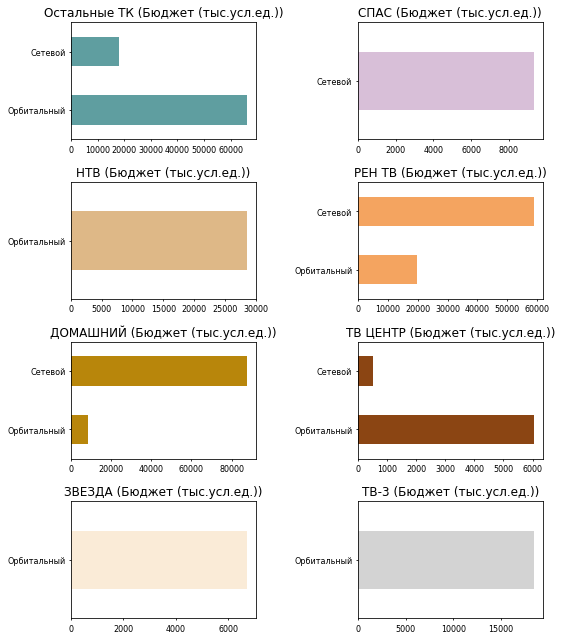

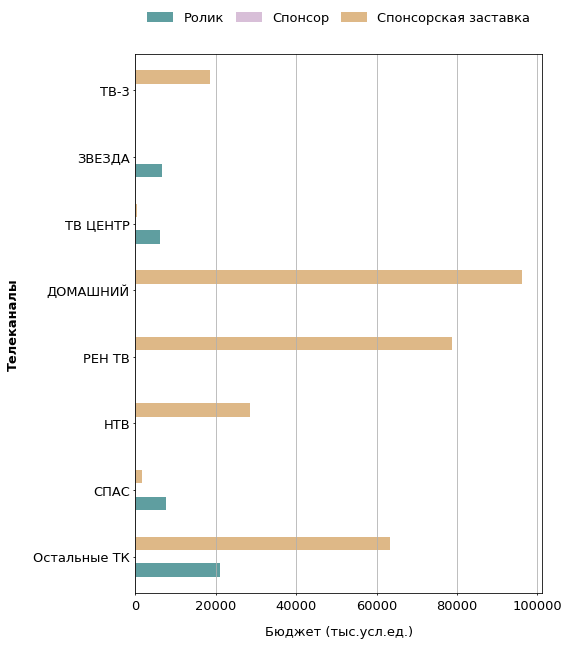

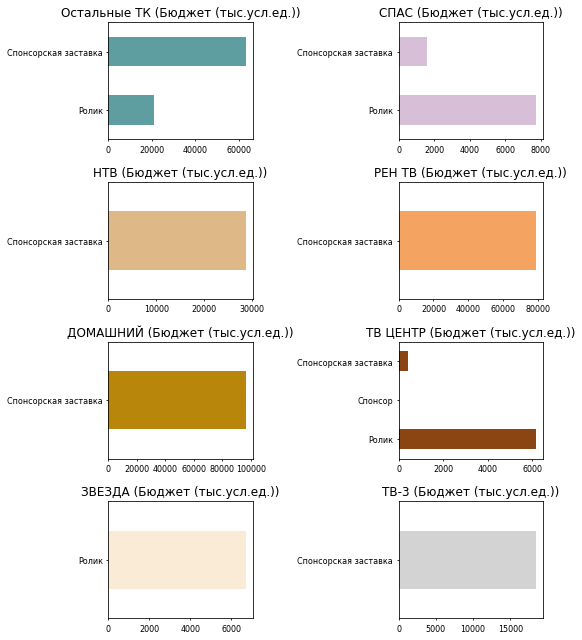

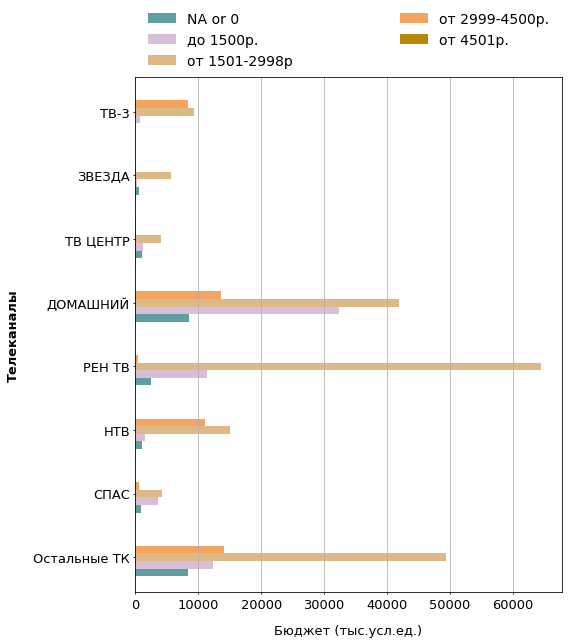

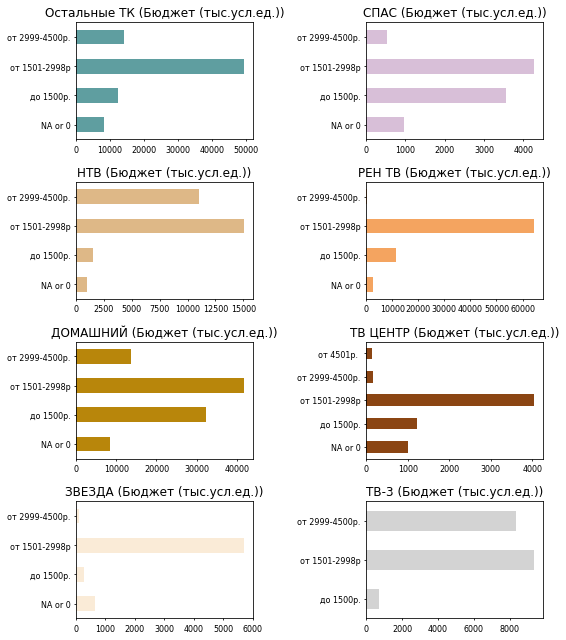

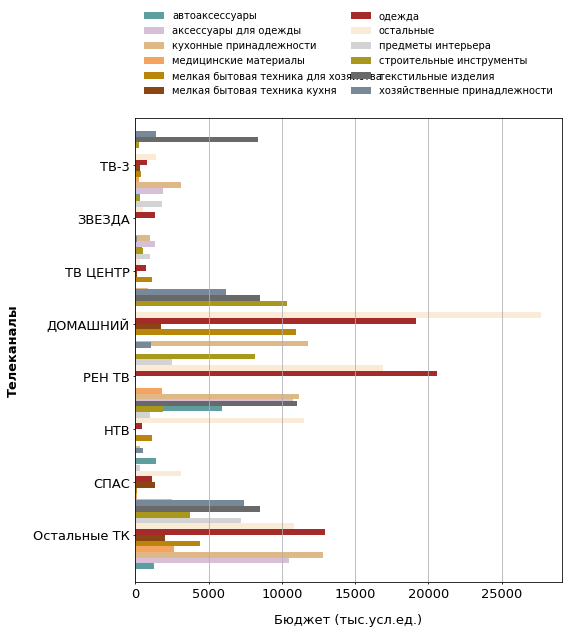

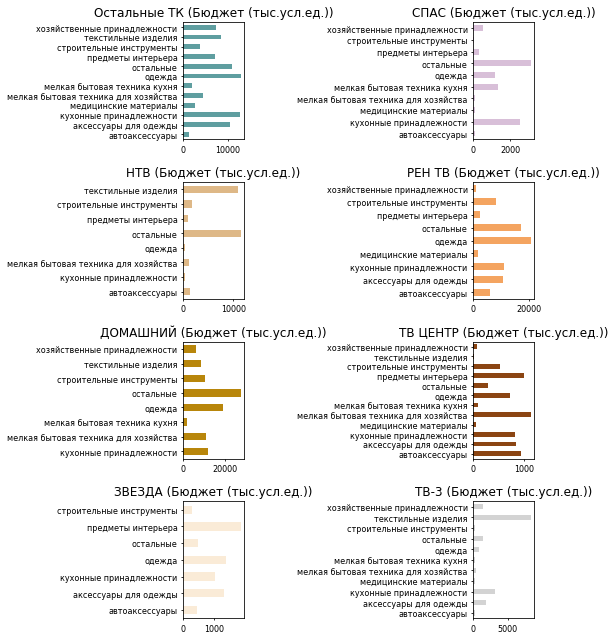

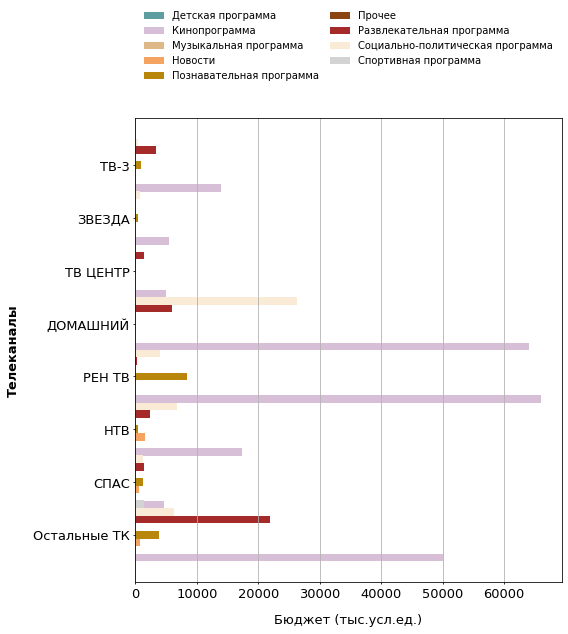

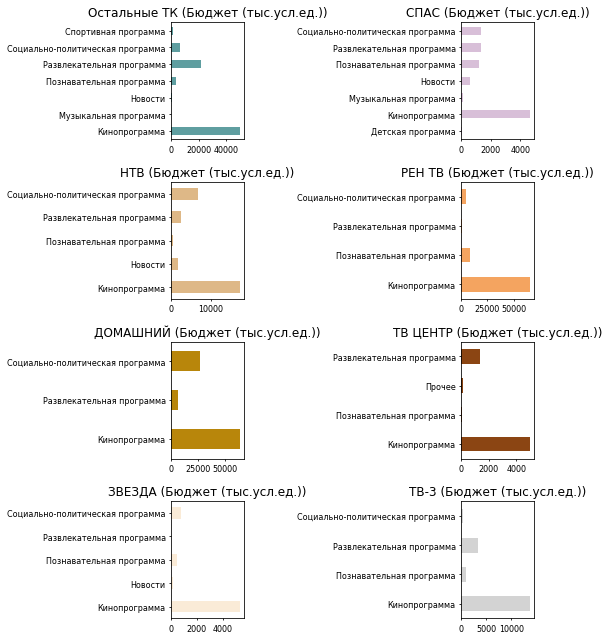

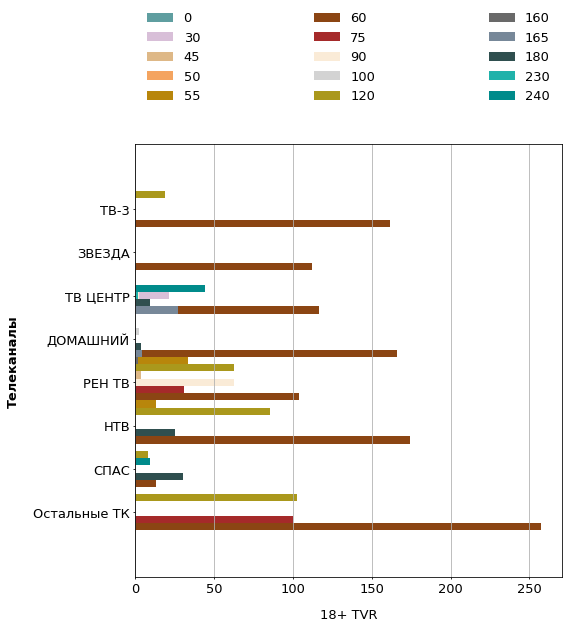

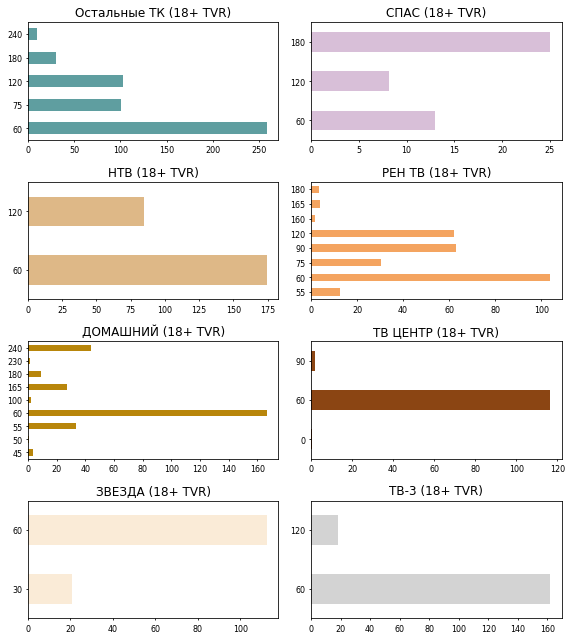

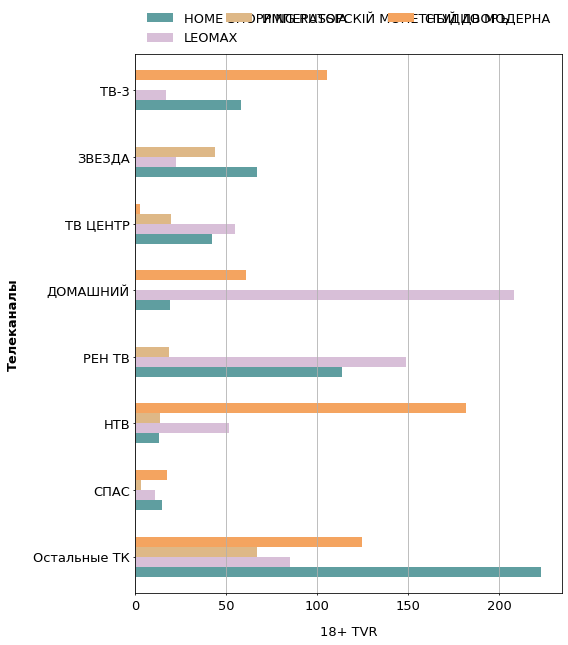

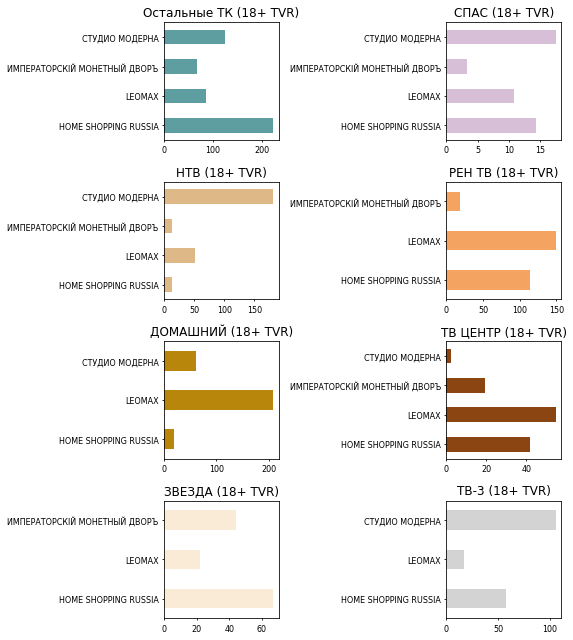

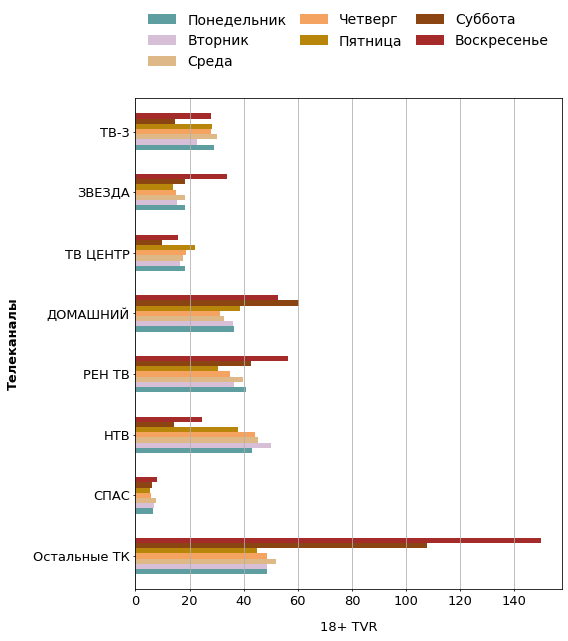

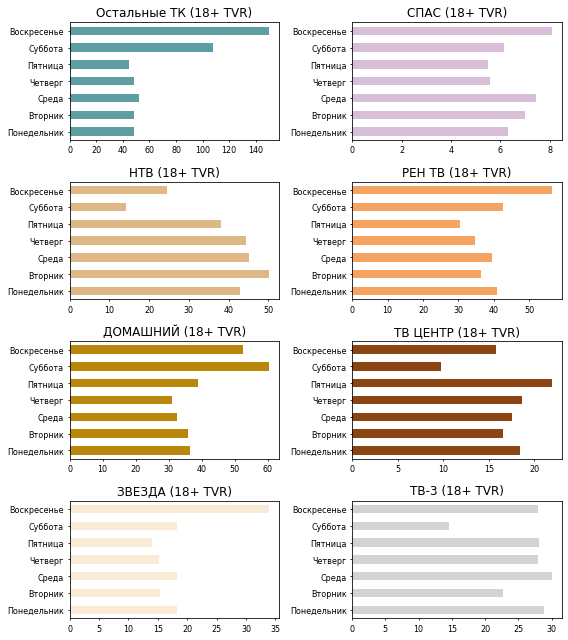

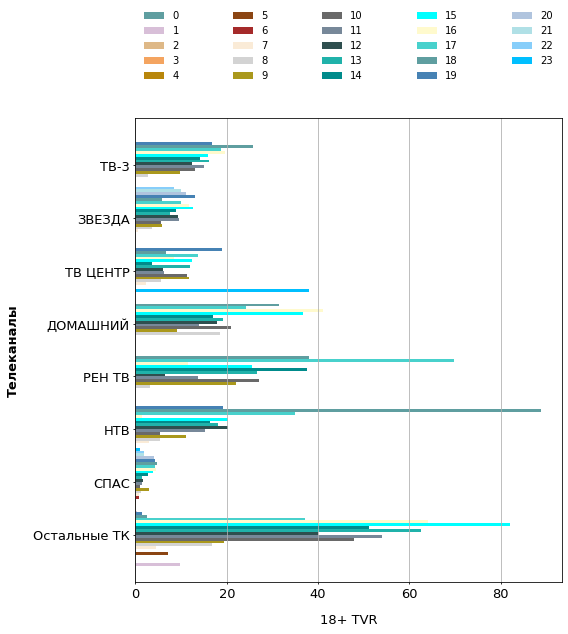

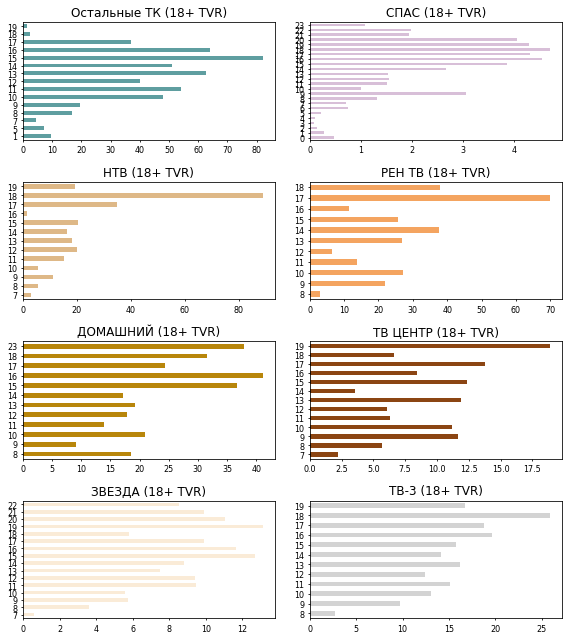

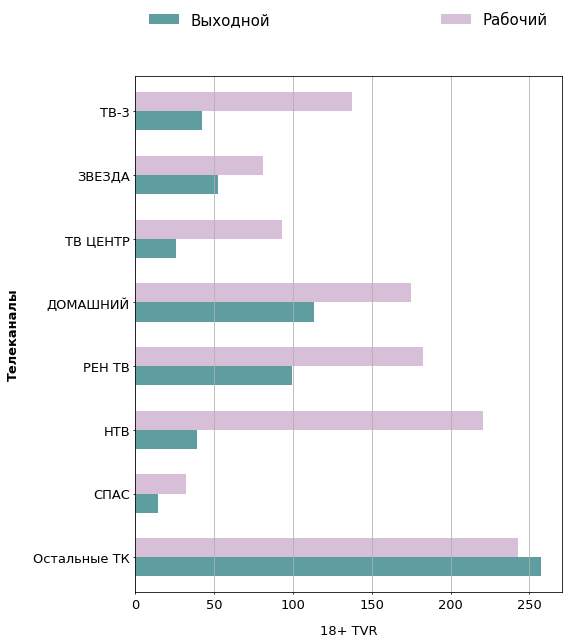

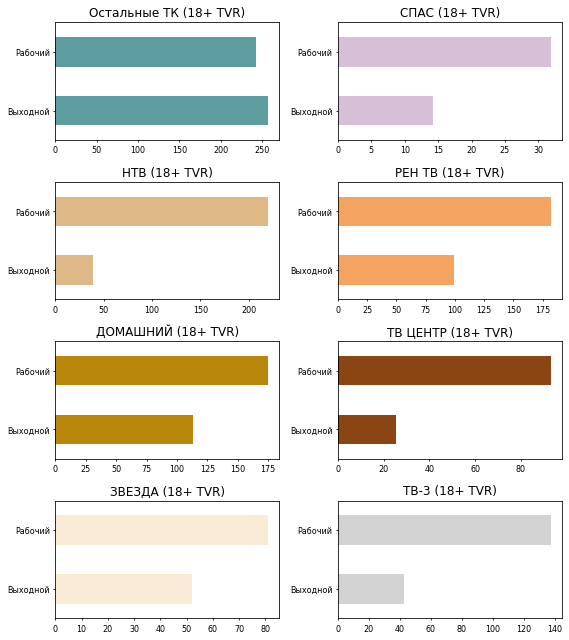

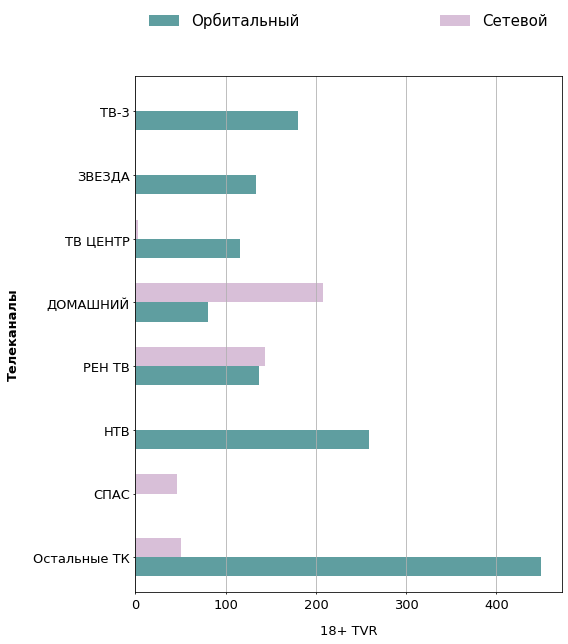

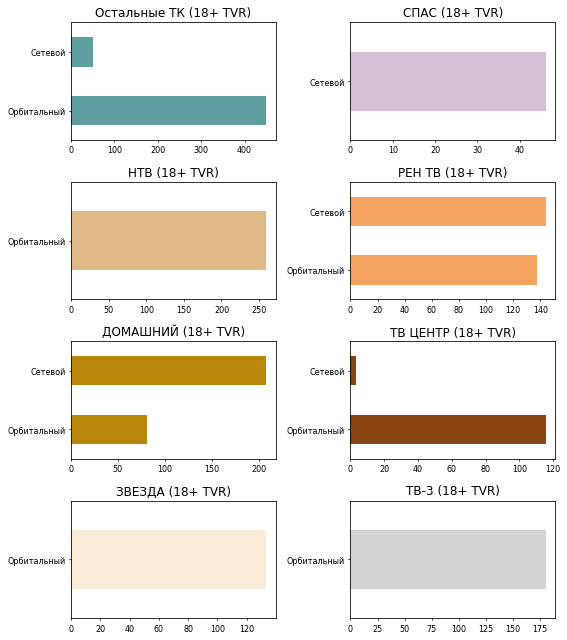

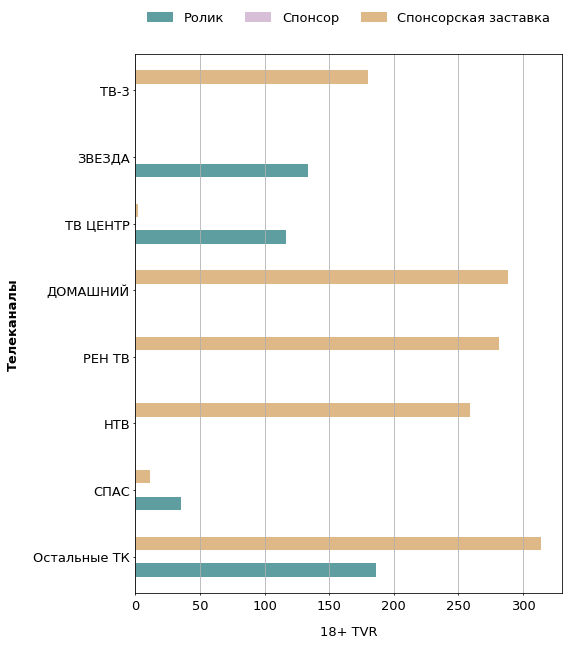

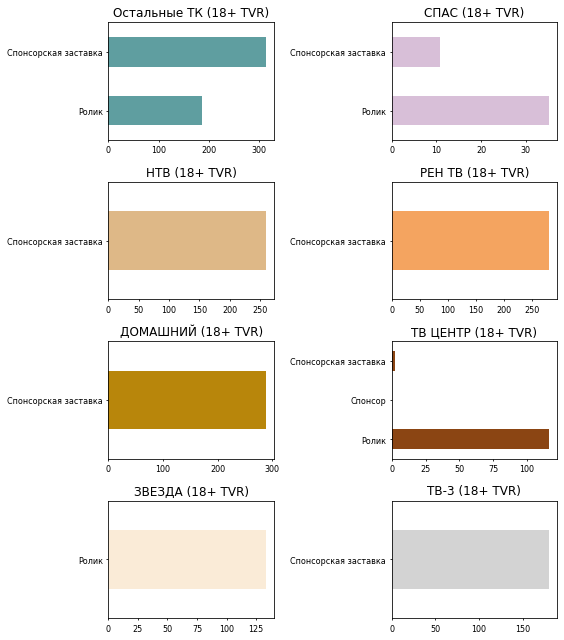

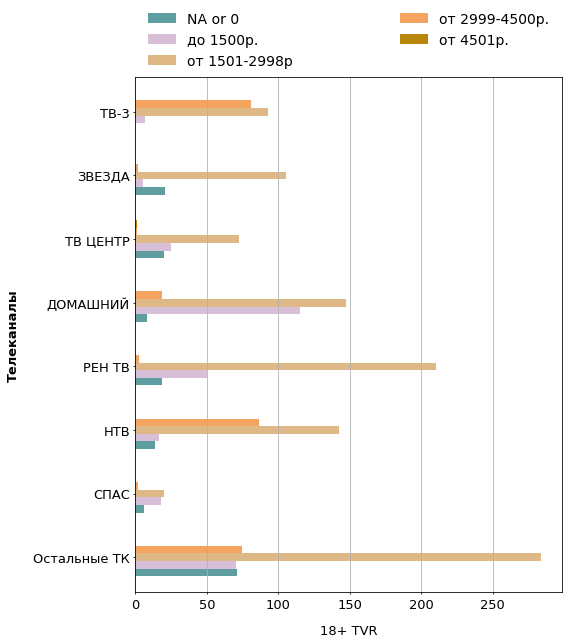

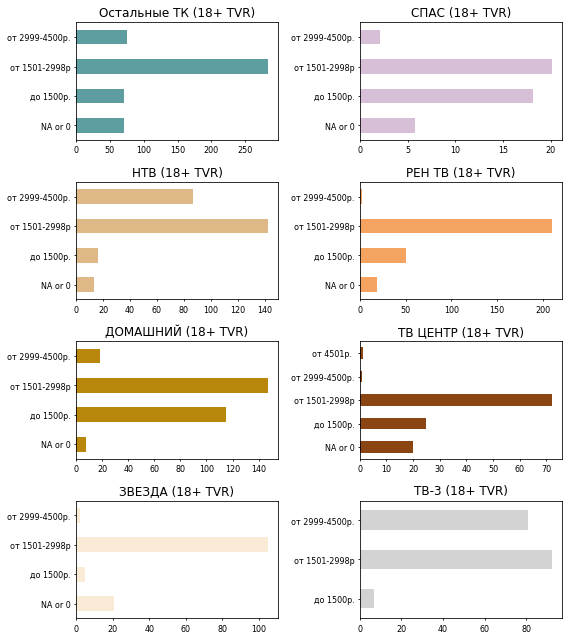

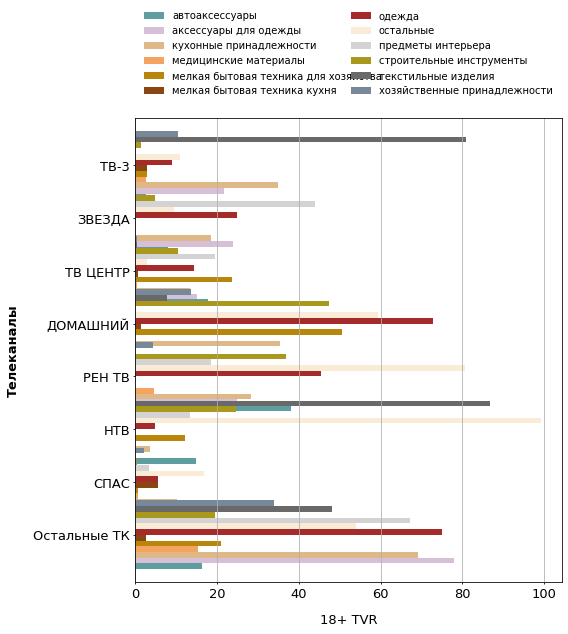

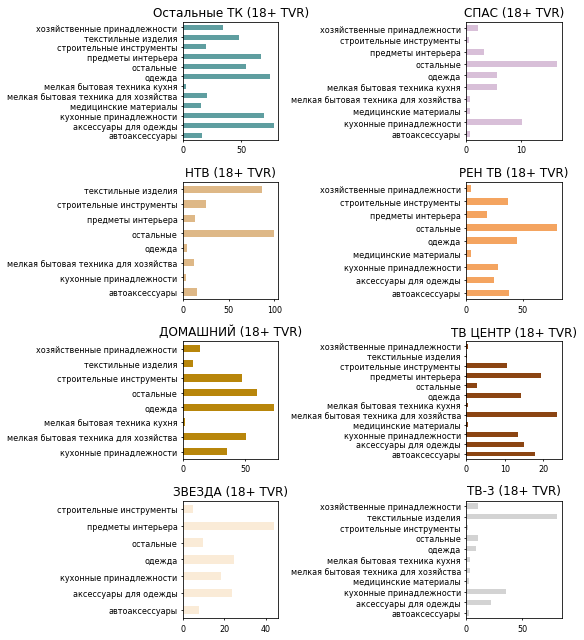

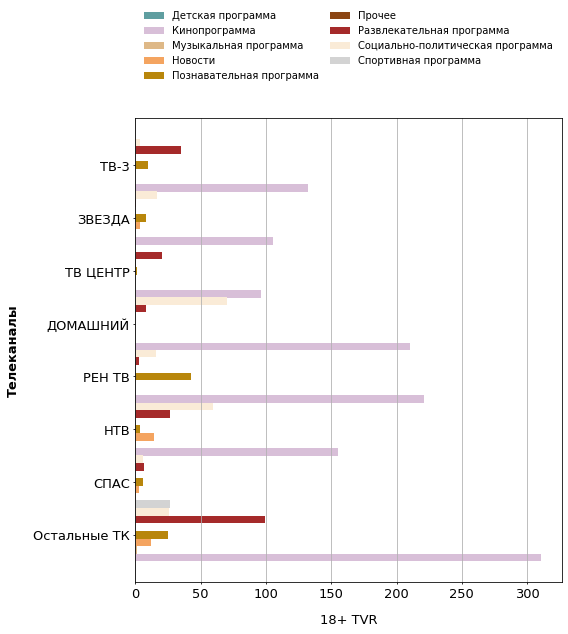

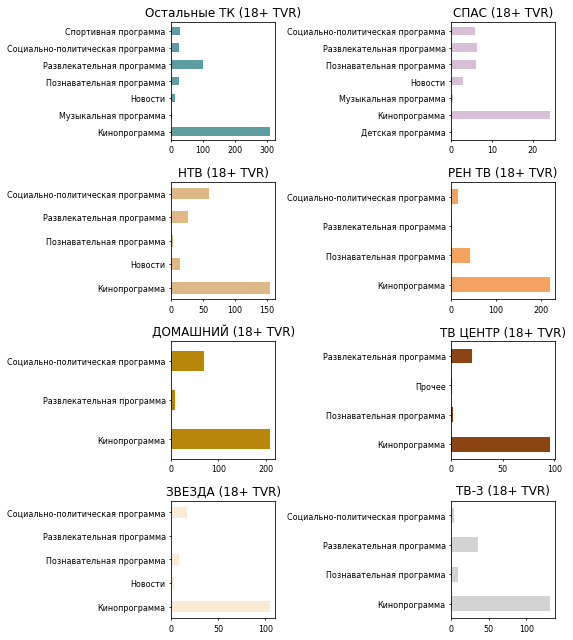

In [33]:
# вывод отчетов

# Для всего отчета - номера недель + None (для месячных отчетов)
# week_list = [i for i in range (WEEKMIN,WEEKMAX + 1)]
# week_list.append(None)  

#Для конкретной недели
week_list = [7]  

for week in week_list:
        
        parametr_for_report_dynamics_list = ['Выходы','Минуты','Бюджет (тыс.усл.ед.)', 'Std. Sales TVR (20)',
                        'Std. Sales TVR (30)','18+ TVR','18+ Stand. TVR (20)','18+ Stand. TVR (30)']
        parametr_for_report_dynamics_list_FR = ['Audience, тыс.чел', 'Reach, тыс.чел','охват 1+ %', 
                                                'охват 4+ %','охват 7+ %','Frequency','CPT Aud (руб)','CPT Reach (руб)']
        parametr_for_report_kol_list = ['Выходы','Минуты','Бюджет (тыс.усл.ед.)','Std. Sales TVR (20)',
                        'Std. Sales TVR (30)','18+ TVR','18+ Stand. TVR (20)','18+ Stand. TVR (30)']
        parametr_for_report_kol_list_FR = ['Audience, тыс.чел', 'Reach, тыс.чел','охват 1+ %',
                                          'охват 4+ %','охват 7+ %','Frequency','CPT Aud (руб)','CPT Reach (руб)']

        parameter_for_structure_list_cut = ['Длительность роликов (сек)','Рекламодатели','День недели',
                                            "Час_выхода", 'Тип дня недели','Дистрибьюция ролика', 
                                            'Формат ролика',"Цена товара (руб.)", "Категория товара (сокр)","Жанр_программы"]

        structure_value_list_cut = ["Минуты", "Выходы",'Бюджет (тыс.усл.ед.)', '18+ TVR' ] 
        title_structure_list_cut = ['Структура по длительности роликов (сек)', 'Структура по рекламодателям','Структура по дням недели',
                                    'Структура по часу выхода', 'Структура по типу дня ', 
                                    'Структура по дистрибьюции роликов', 'Структура по формату роликов',
                                    'Структура по цене товара','Структура по категории рекламируемого товара',
                                    "Структура по жанру программы"]
        structure_value_list =[]
        for i in structure_value_list_cut:
            for k in range(0,len(parameter_for_structure_list_cut)):
                structure_value_list.append(i)

        parameter_for_structure_list = parameter_for_structure_list_cut * len(structure_value_list_cut)
        title_structure_list = title_structure_list_cut * len(structure_value_list_cut)
        title_dynamics_list = ['Динамика выходов по основным Телеканалам',                            
                                    'Динамика минут по основным Телеканалам',
                                  'Динамика бюджетов (тыс.усл.ед.) по основным Телеканалам',
                                    'Динамика Std.Sales TVR(20) по основным Телеканалам',
                                    'Динамика Std.Sales TVR(30) по основным Телеканалам',
                                    'Динамика 18+ TVR по основным Телеканалам',
                                    'Динамика 18+ Stand. TVR(20) по основным Телеканалам',
                                  'Динамика 18+ Stand. TVR(30) по основным Телеканалам']
        title_dynamics_list_FR = ['Динамика  4+ Audience тыс.чел  по основным Телеканалам',
                                    'Динамика 4+ Reach тыс.чел  по основным Телеканалам',
                                    'Динамика 4+ Reach1+ % по основным Телеканалам',
                                    'Динамика 4+ Reach4+ % по основным Телеканалам',
                                    'Динамика 4+ Reach7+ % по основным Телеканалам',
                                    'Динамика 4+ Frequency  по основным Телеканалам ',
                                    'Динамика 4+ CPT на Audience(усл.ед.) по основным Телеканалам',
                                    'Динамика 4+ CPT на Reach(усл.ед.) по основным Телеканалам']
        title_kol_list = ['Доля выходов по основным Телеканалам',                            
                                    'Доля минут по основным Телеканалам',
                                  'Доля бюджетов (тыс.усл.ед.) по основным Телеканалам',
                                    'Доля Std.Sales TVR(20) по основным Телеканалам',
                                    'Доля Std.Sales TVR(30) по основным Телеканалам',
                                    'Доля 18+ TVR по основным Телеканалам',
                                    'Доля 18+ Stand. TVR(20) по основным Телеканалам',
                                  'Доля 18+ Stand. TVR(30) по основным Телеканалам']
        title_kol_list_FR = ['Доля 4+ Audience тыс.чел по основным Телеканалам',
                                    'Доля 4+ Reach тыс.чел  по основным Телеканалам ',
                                    'Доля 4+ Reach1+ % по основным Телеканалам ',
                                      'Доля 4+ Reach4+ % по основным Телеканалам',
                                    'Доля 4+ Reach7+ % по основным Телеканалам',
                                    'Доля 4+ Frequency по основным Телеканалам',
                                    'Доля 4+ CPT на Audience(усл.ед.) по основным Телеканалам',
                                    'Доля 4+ CPT на Reach(усл.ед.) по основным Телеканалам']

        definition_dynamics_list = def_definition_list(parametr_for_report_dynamics_list)          
        definition_kol_list = def_definition_list(parametr_for_report_kol_list)          
        definition_dynamics_list_FR = def_definition_list(parametr_for_report_dynamics_list_FR)
        definition_kol_list_FR = def_definition_list(parametr_for_report_kol_list_FR)

        form_html_report(FileReport, week_list, MONTH, parametr_for_report_dynamics_list,parametr_for_report_dynamics_list_FR, 
                            title_dynamics_list, title_dynamics_list_FR, definition_dynamics_list, definition_dynamics_list_FR,
                        parametr_for_report_kol_list,  parametr_for_report_kol_list_FR, title_kol_list, title_kol_list_FR, 
                        definition_kol_list, definition_kol_list_FR,  parameter_for_structure_list, structure_value_list,
                        title_structure_list)

        weasyprint.HTML(html_file).write_pdf("TV_reports_pdf_file{}.pdf".format(week))

